In [385]:
import os
import sys
import pickle
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib import ticker

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [178]:

def extract_clp_results(clustering_dict, Nframes, Nexp, rmax_list, act_list, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    LX = clustering_dict['LX']
    suffix = clustering_dict['suffix']
    Nwindows = len(rmax_list)
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, Nwindows, 3, len(act_list), Nexp])
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            cl_res = np.load(os.path.join(exp_dir, 'cl_arr.npy'))
            ff_idx = min(Nframes, cl_res.shape[0])
            cluster_arr[-ff_idx:,:cl_res.shape[1],:,i,j] = cl_res[-ff_idx:] 

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr

def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
        nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
        ff_idx = min(Nframes, cl_res.shape[0])
        cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        defect_positions[i] = *defect['pos'], defect['charge'] if return_charge else defect['pos']
    return defect_positions

def get_clustering_signed(top_defect_list, method, rmax_list, method_kwargs, save = False, save_path = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)
        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        if defect_positions is None:
            continue

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs)
            labels = cst.fit_predict(defect_positions)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

    if save:
        # save labels list
        save_path = save_path if save_path is not None else 'labels_list.pkl'
        np.save(save_path, cl_arr)
    return cl_arr

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects

def find_conv_time(def_arr, act_list, out_path, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                   stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1)):

    Nframes, Nact = def_arr.shape
    conv_list = np.zeros(Nact)

    ncols=3
    nrows = np.ceil(Nact / ncols).astype(int)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
    ax = ax.flatten()


    for i, act in enumerate(act_list):

            normalizer = LX ** 2 if plot_density else 1
            vals = def_arr[:, i] / normalizer

            av = np.mean(vals)
        

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                x = est_stationarity(vals, **stationarity_dict)[0]

            conv_list[i] = x
            ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                        alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
        
            if x > 0:
                ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
            ax[i].set_ylim([0, 2 * av])
            ax[i].legend()  
            ax[i].grid(True)


    fig.supxlabel('Time')
    fig.supylabel('Number of defects')


    np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}{LX}.png'))

    # close figure
    plt.close(fig)
    return

def calc_lmax_lperc(clp_arr, rmax_list, act_list, conv_list, save_path, uncertainty_multiplier = 1, nmin_frames = 20):
    

    lmax_av = np.nan * np.zeros((len(act_list), 2))
    lperc_av = np.nan * np.zeros((len(act_list), 2))

    arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)
    lmax_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, -1, :,])
    lperc_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, 0, :,])

    for i, _ in enumerate(act_list):
        ff_idx = int(conv_list[i])

        mask = (lmax_arr[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples > nmin_frames:
            arr_res = lmax_arr[ff_idx:, i,][mask]
            lmax_av[i,0] = np.nanmean(arr_res)
            lmax_av[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


        mask_perc = (lperc_arr[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc  > nmin_frames:
            arr_res_perc = lperc_arr[ff_idx:, i,][mask_perc]
            lperc_av[i,0] = np.nanmean(arr_res_perc)
            lperc_av[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    np.save(os.path.join(save_path, 'lmax_arr.npy'), lmax_arr)
    np.save(os.path.join(save_path, 'lperc_arr.npy'), lperc_arr)
    np.save(os.path.join(save_path, 'lmax_av.npy'), lmax_av)
    np.save(os.path.join(save_path, 'lperc_av.npy'), lperc_av)
    return

In [199]:
LX = 256
mode = 'wet'

lambda_list = [0, .1, .5, .8, 1] # .1, .5, .8] # .5, .8]#, 0.1, 0.5, 0.8]
out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}'

extract = False
extract_def = False
find_conv = False
analyze= False
analyze_per_frame = True #if mode == 'dry' else False
plot_figs = True
save_figs = True

for lambda_val in lambda_list:
    #base_path_fwd = f'X:\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}\\fwd'
    #base_path_bck = f'X:\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}\\bck'

    base_path_fwd = f'X:\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}\\fwd'
    base_path_bck = f'X:\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}\\bck'

    #out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}'
    
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')
    fig_path = os.path.join(out_path_main, 'figs')

    if extract:
        if not os.path.isdir(fig_path):
            os.makedirs(fig_path)
        if not os.path.isdir(out_path_main):
            os.makedirs(out_path_main)
        if not os.path.isdir(out_path_fwd):
            os.makedirs(out_path_fwd)
        if not os.path.isdir(out_path_bck):
            os.makedirs(out_path_bck)

        print(f'Analyzing {mode} with lambda = {lambda_val}')
        t1 = time.perf_counter()    

        act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
        act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

        act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
        act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

        # save activity list
        np.save(os.path.join(out_path_fwd, 'act_fwd.npy'), act_fwd)
        np.save(os.path.join(out_path_bck, 'act_bck.npy'), act_bck)
    else:
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)
    Nact_list = [Nact_fwd, Nact_bck]

    rmax_list = np.arange(1, int(LX / np.sqrt(2))) #if mode == 'wet' and LX==512 else np.arange(1, LX / 2,)
    Nframes = 1000 # if lambda_val !=1 else 200
    Nwindows = len(rmax_list)
    ninfo = 1000

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_fwd), \
                        Nwindows = len(rmax_list), \
                        path = out_path_fwd, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_bck), \
                        Nwindows = len(rmax_list), \
                        path = out_path_bck, suffix = '_bck')

    if extract:
        clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path_fwd)
        clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path_bck)

        if extract_def:
            def_arr_fwd = np.zeros([Nframes, Nact_fwd])
            def_arr_bck = np.zeros([Nframes, Nact_bck])

            for i, (act_dir_list, arr) in enumerate(zip([act_dirs_fwd, act_dirs_bck], [def_arr_fwd, def_arr_bck])):
                print("Extracting defects for", 'fwd' if i == 0 else 'bck')
                for j, act_dir in enumerate(act_dir_list):
                    print(j)
                    path = os.path.join(act_dir, 'defect_positions.pkl')
                    with open(path, 'rb') as f:
                        defect_dict = pickle.load(f)
                    def_list_pos = get_defect_density(defect_dict, area = 1)
                    ff_idx = min(Nframes, len(def_list_pos))
                    arr[-ff_idx:, j] = def_list_pos[-ff_idx:]

            # save 
            np.save(os.path.join(out_path_fwd, 'def_arr.npy'), def_arr_fwd)
            np.save(os.path.join(out_path_bck, 'def_arr.npy'), def_arr_bck)
        else:
            def_arr_fwd = np.load(os.path.join(f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}', 'def_arr_fwd.npy'))
            def_arr_bck = np.load(os.path.join(f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}', 'def_arr_bck.npy'))
            np.save(os.path.join(out_path_fwd, 'def_arr.npy'), def_arr_fwd)
            np.save(os.path.join(out_path_bck, 'def_arr.npy'), def_arr_bck)

    else:
        clp_arr_fwd = np.load(os.path.join(out_path_fwd, 'clp_arr.npy'))
        clp_arr_bck = np.load(os.path.join(out_path_bck, 'clp_arr.npy'))
        def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
        def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
        nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
        nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))

    if not find_conv:
        try:
            conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
            conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
        except:
            conv_list_bck = np.zeros(Nact_bck)
            conv_list_fwd = np.zeros(Nact_fwd)
    else:

        find_conv_time(def_arr_fwd, act_fwd, out_path_fwd, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1))
        find_conv_time(def_arr_bck, act_bck, out_path_bck, fig_path, ninfo, LX, mode='bck', plot_density = False, \
                stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1))


    if analyze:
        print('Analyzing', lambda_val) 
        calc_lmax_lperc(clp_arr_fwd, rmax_list, act_fwd, conv_list_fwd, out_path_fwd, uncertainty_multiplier = 1, nmin_frames = 20)
        calc_lmax_lperc(clp_arr_bck, rmax_list, act_bck, conv_list_bck, out_path_bck, uncertainty_multiplier = 1, nmin_frames = 20)

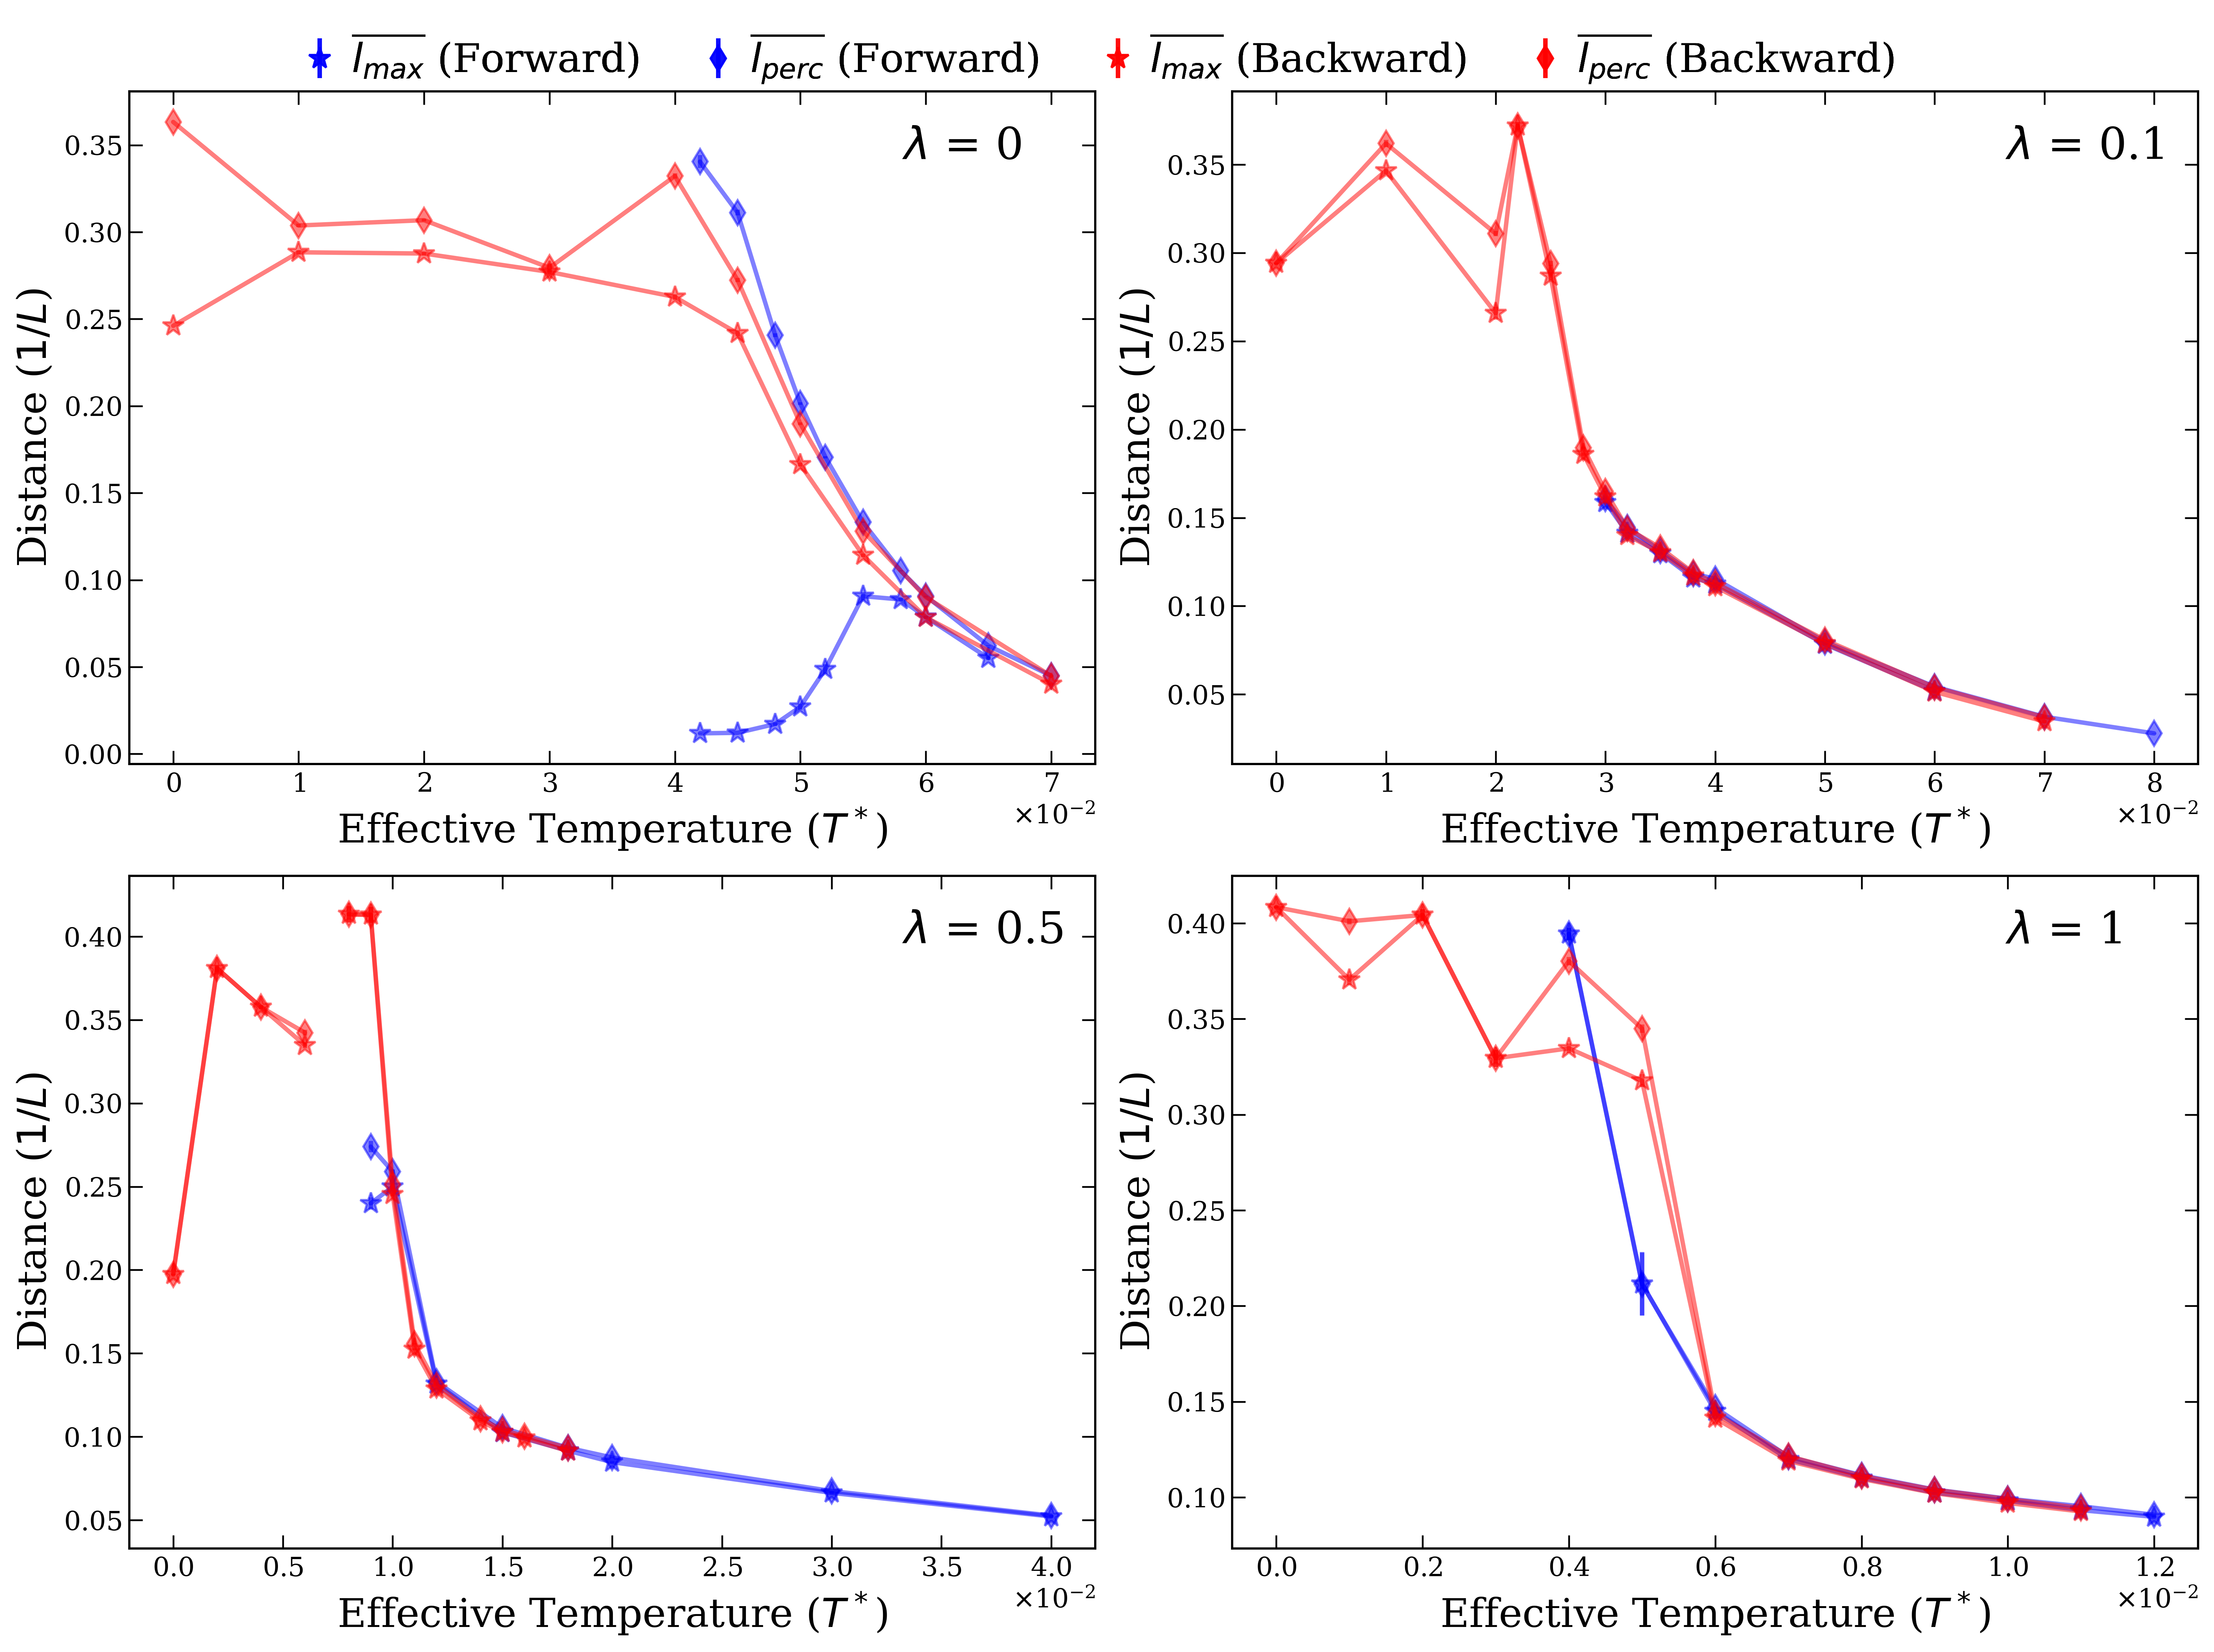

In [200]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(14, 10))
ax = ax.flatten()
normalize=True
for i, lambda_val in enumerate([0,.1,.5,1]):
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer


    ax[i].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.5,ms=10,fmt='b*-', label=r'$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.5,ms=8, fmt='d-',color='blue', label=r'$\overline{l_{perc}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{perc}}$')
    #ax[0].title.set_text('Forward')
    #ax[0].legend()  

    ax[i].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.5, ms=10,fmt='r*-', label=r'$\overline{l_{max}}$ (Backward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], ms=8,alpha=.5,fmt='rd-', label=r'$\overline{l_{perc}}$ (Backward)' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    #ax[i].legend()
    ax[i].set_xlabel(r'Effective Temperature ($T^*$)')
    ax[i].set_ylabel(r'Distance ($1/L$)')
    ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045))
    #fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
    save_path = os.path.join(out_path_all, 'figs')
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    fig.savefig(os.path.join(save_path, f'lmax_lperc_{mode}.png')) 

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13536\4142581986.py:22: RuntimeWarning: divide by zero encountered in divide
  rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13536\4142581986.py:22: RuntimeWarning: invalid value encountered in divide
  rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13536\4142581986.py:25: RuntimeWarning: Mean of empty slice
  rel_diff_fwd_av = np.nanmean(rel_diff_fwd, axis=0)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13536\4142581986.py:23: RuntimeWarning: invalid value encountered in divide
  rel_diff_bck = np.abs(np.diff(def_arr_bck, axis=0)) / def_arr_bck[:-1]


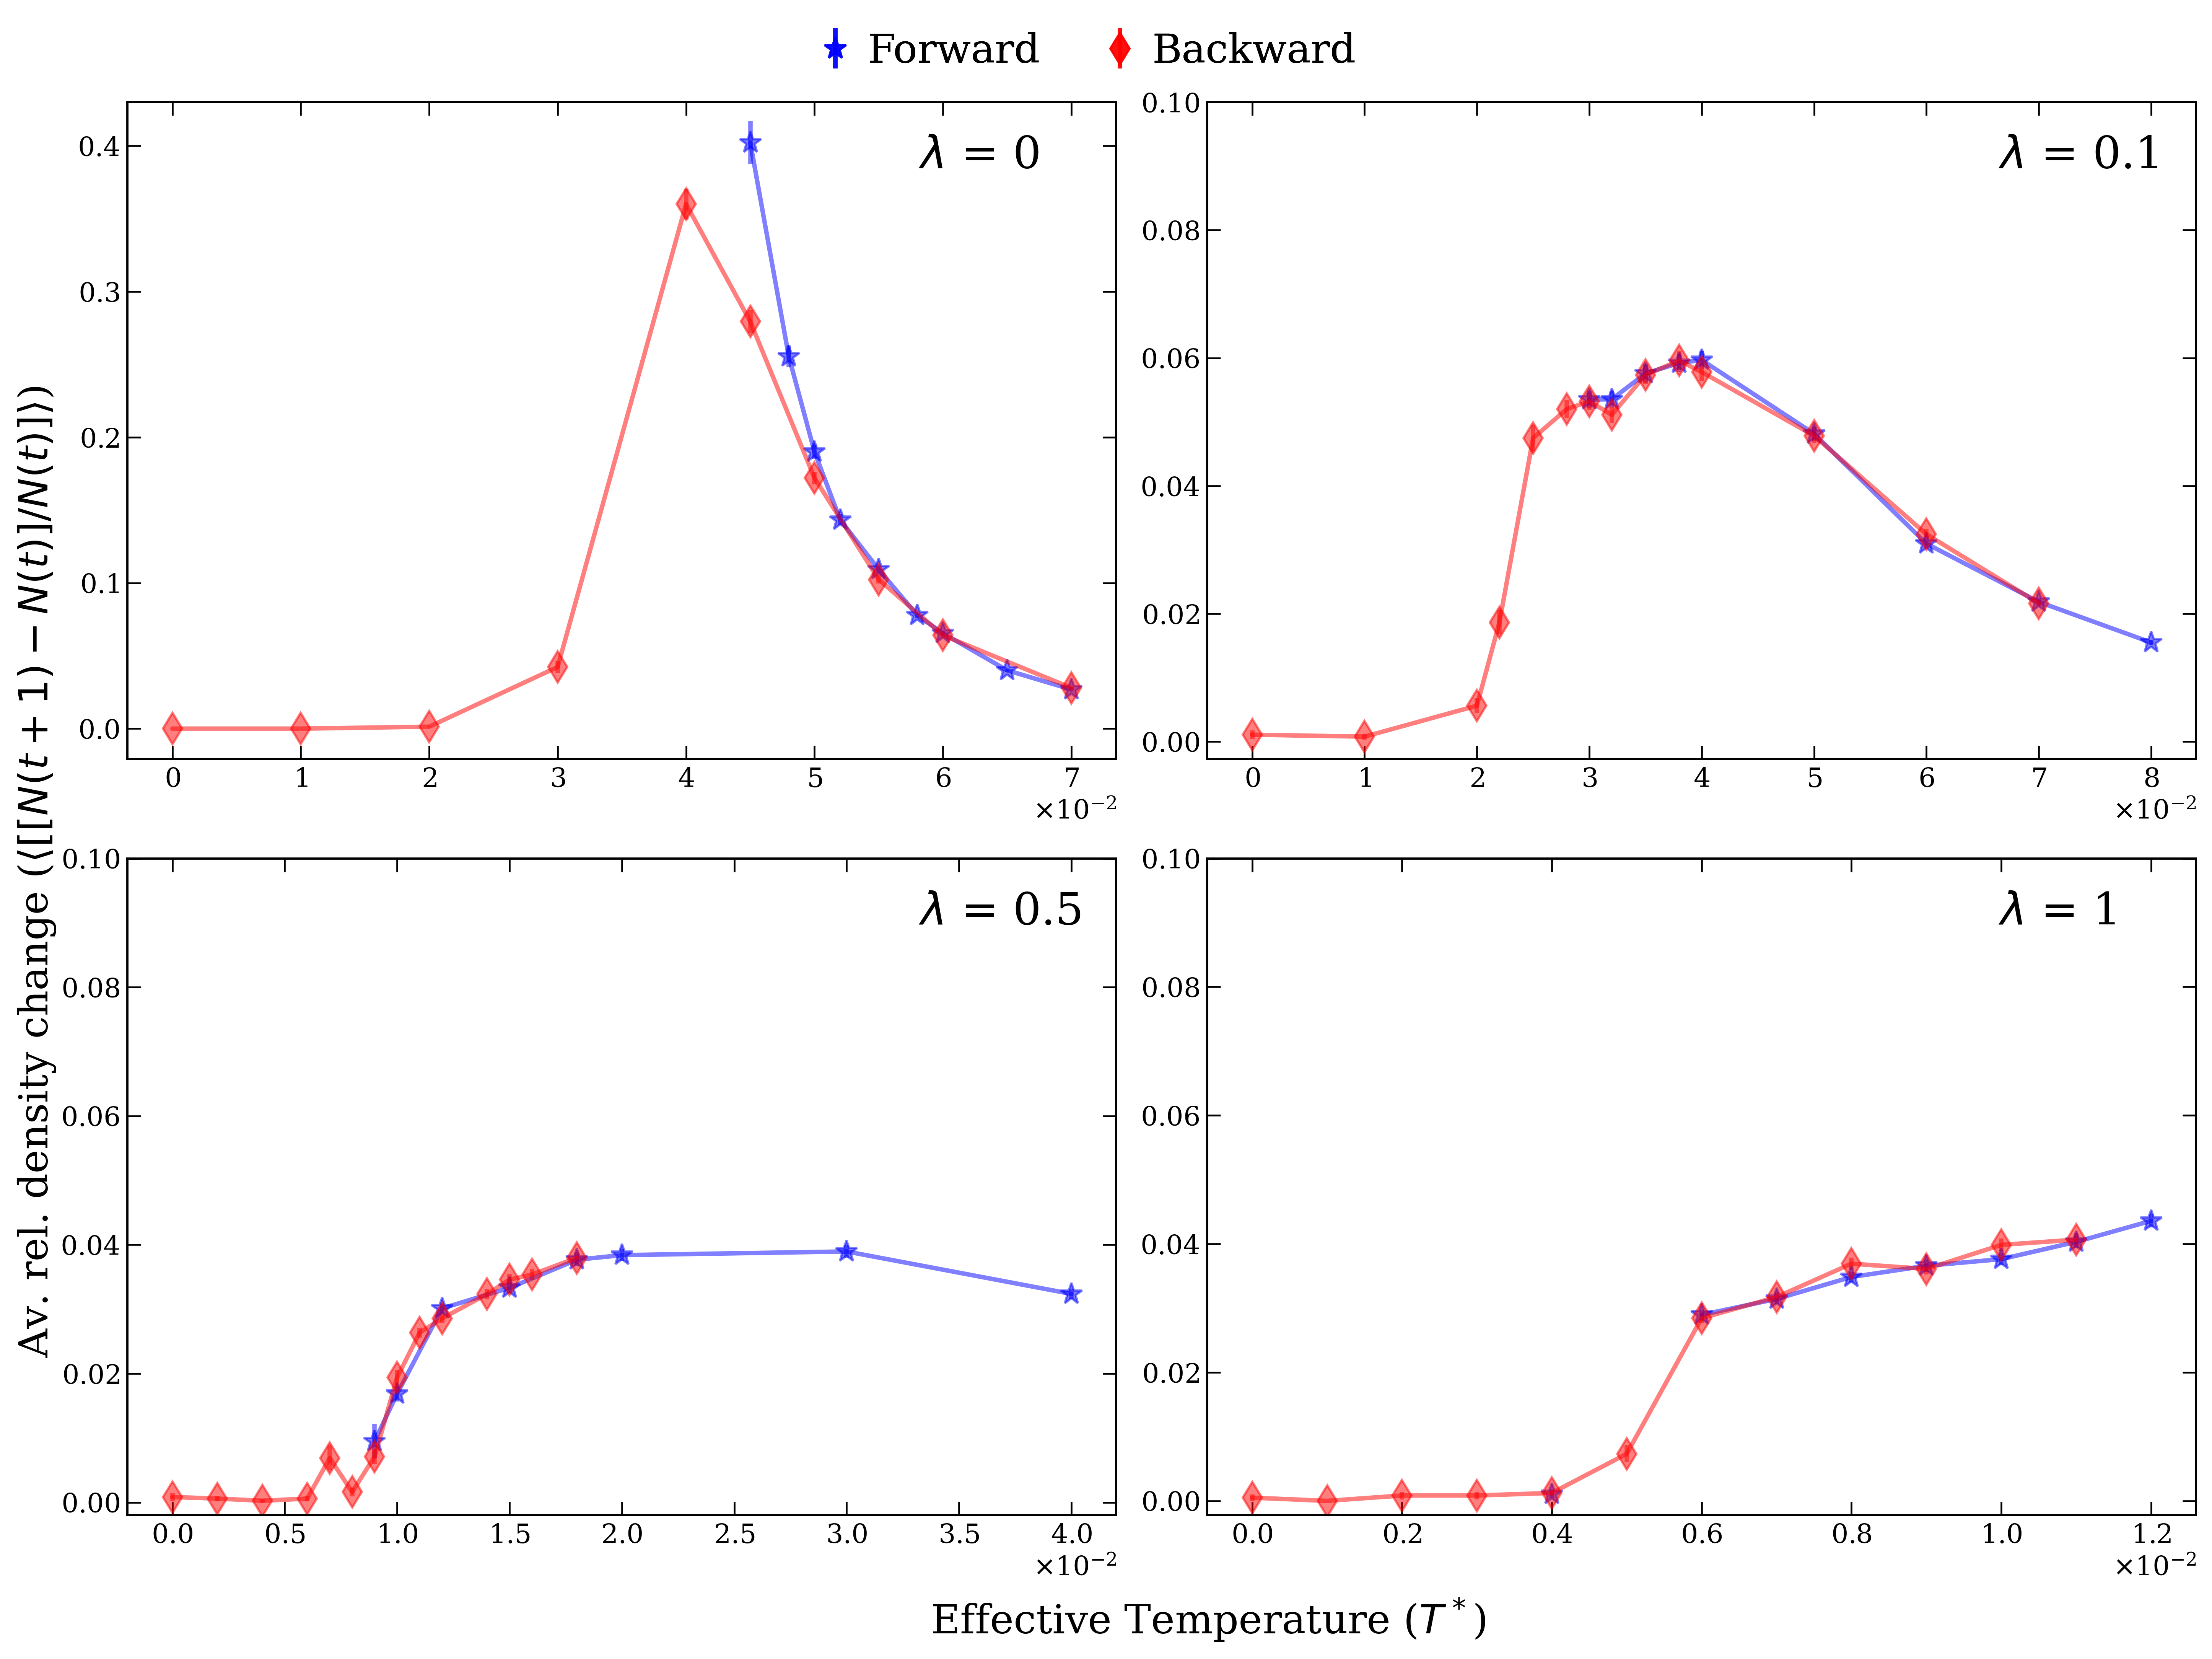

In [255]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(14, 10))
ax = ax.flatten()

normalize=True
for i, lambda_val in enumerate([0,.1,.5,1]):
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer

    rel_diff_fwd = np.abs(np.diff(def_arr_fwd, axis=0)) / def_arr_fwd[:-1]
    rel_diff_bck = np.abs(np.diff(def_arr_bck, axis=0)) / def_arr_bck[:-1]

    rel_diff_fwd_av = np.nanmean(rel_diff_fwd, axis=0)
    rel_diff_fwd_std = np.nanstd(rel_diff_fwd, axis=0) / np.sqrt(rel_diff_fwd.shape[0])
    rel_diff_bck_av = np.nanmean(rel_diff_bck, axis=0)
    rel_diff_bck_std = np.nanstd(rel_diff_bck, axis=0) / np.sqrt(rel_diff_bck.shape[0])


    ax[i].errorbar(act_fwd, rel_diff_fwd_av[:len(act_fwd)], yerr=rel_diff_fwd_std[:len(act_fwd)], alpha=.5,ms=10,fmt='b*-', label=rf'Forward' if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck, rel_diff_bck_av[:len(act_bck)], yerr=rel_diff_bck_std[:len(act_bck)], alpha=.5, ms=10,fmt='rd-', label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    #ax[i].legend()
    #ax[1].legend()  
    #ax[0].set_title('Forward')
    #ax[1].set_title('Backward')
    #ax[i].set_ylim(ymax=0.43)
    ax[i].set_ylim(ymax=0.43 if i==0 else .1)
    #ax[0].set_xlim(xmin=0,xmax=.082)
    #ax[1].set_xlim(xmin=0,xmax=.082)

    fig.supylabel(r'Av. rel. density change ($\langle[[N(t+1)-N(t)] / N(t)] \rangle$)')
    #ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    #fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045))
    fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.02)
    fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045))
    #    .set_xlabel(r'Effective Temperature ($T^*$)')
    save_path = os.path.join(out_path_all, 'figs')
    fig.tight_layout()
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    fig.savefig(os.path.join(save_path, f'density_change.png'), bbox_inches='tight', pad_inches=.1) 

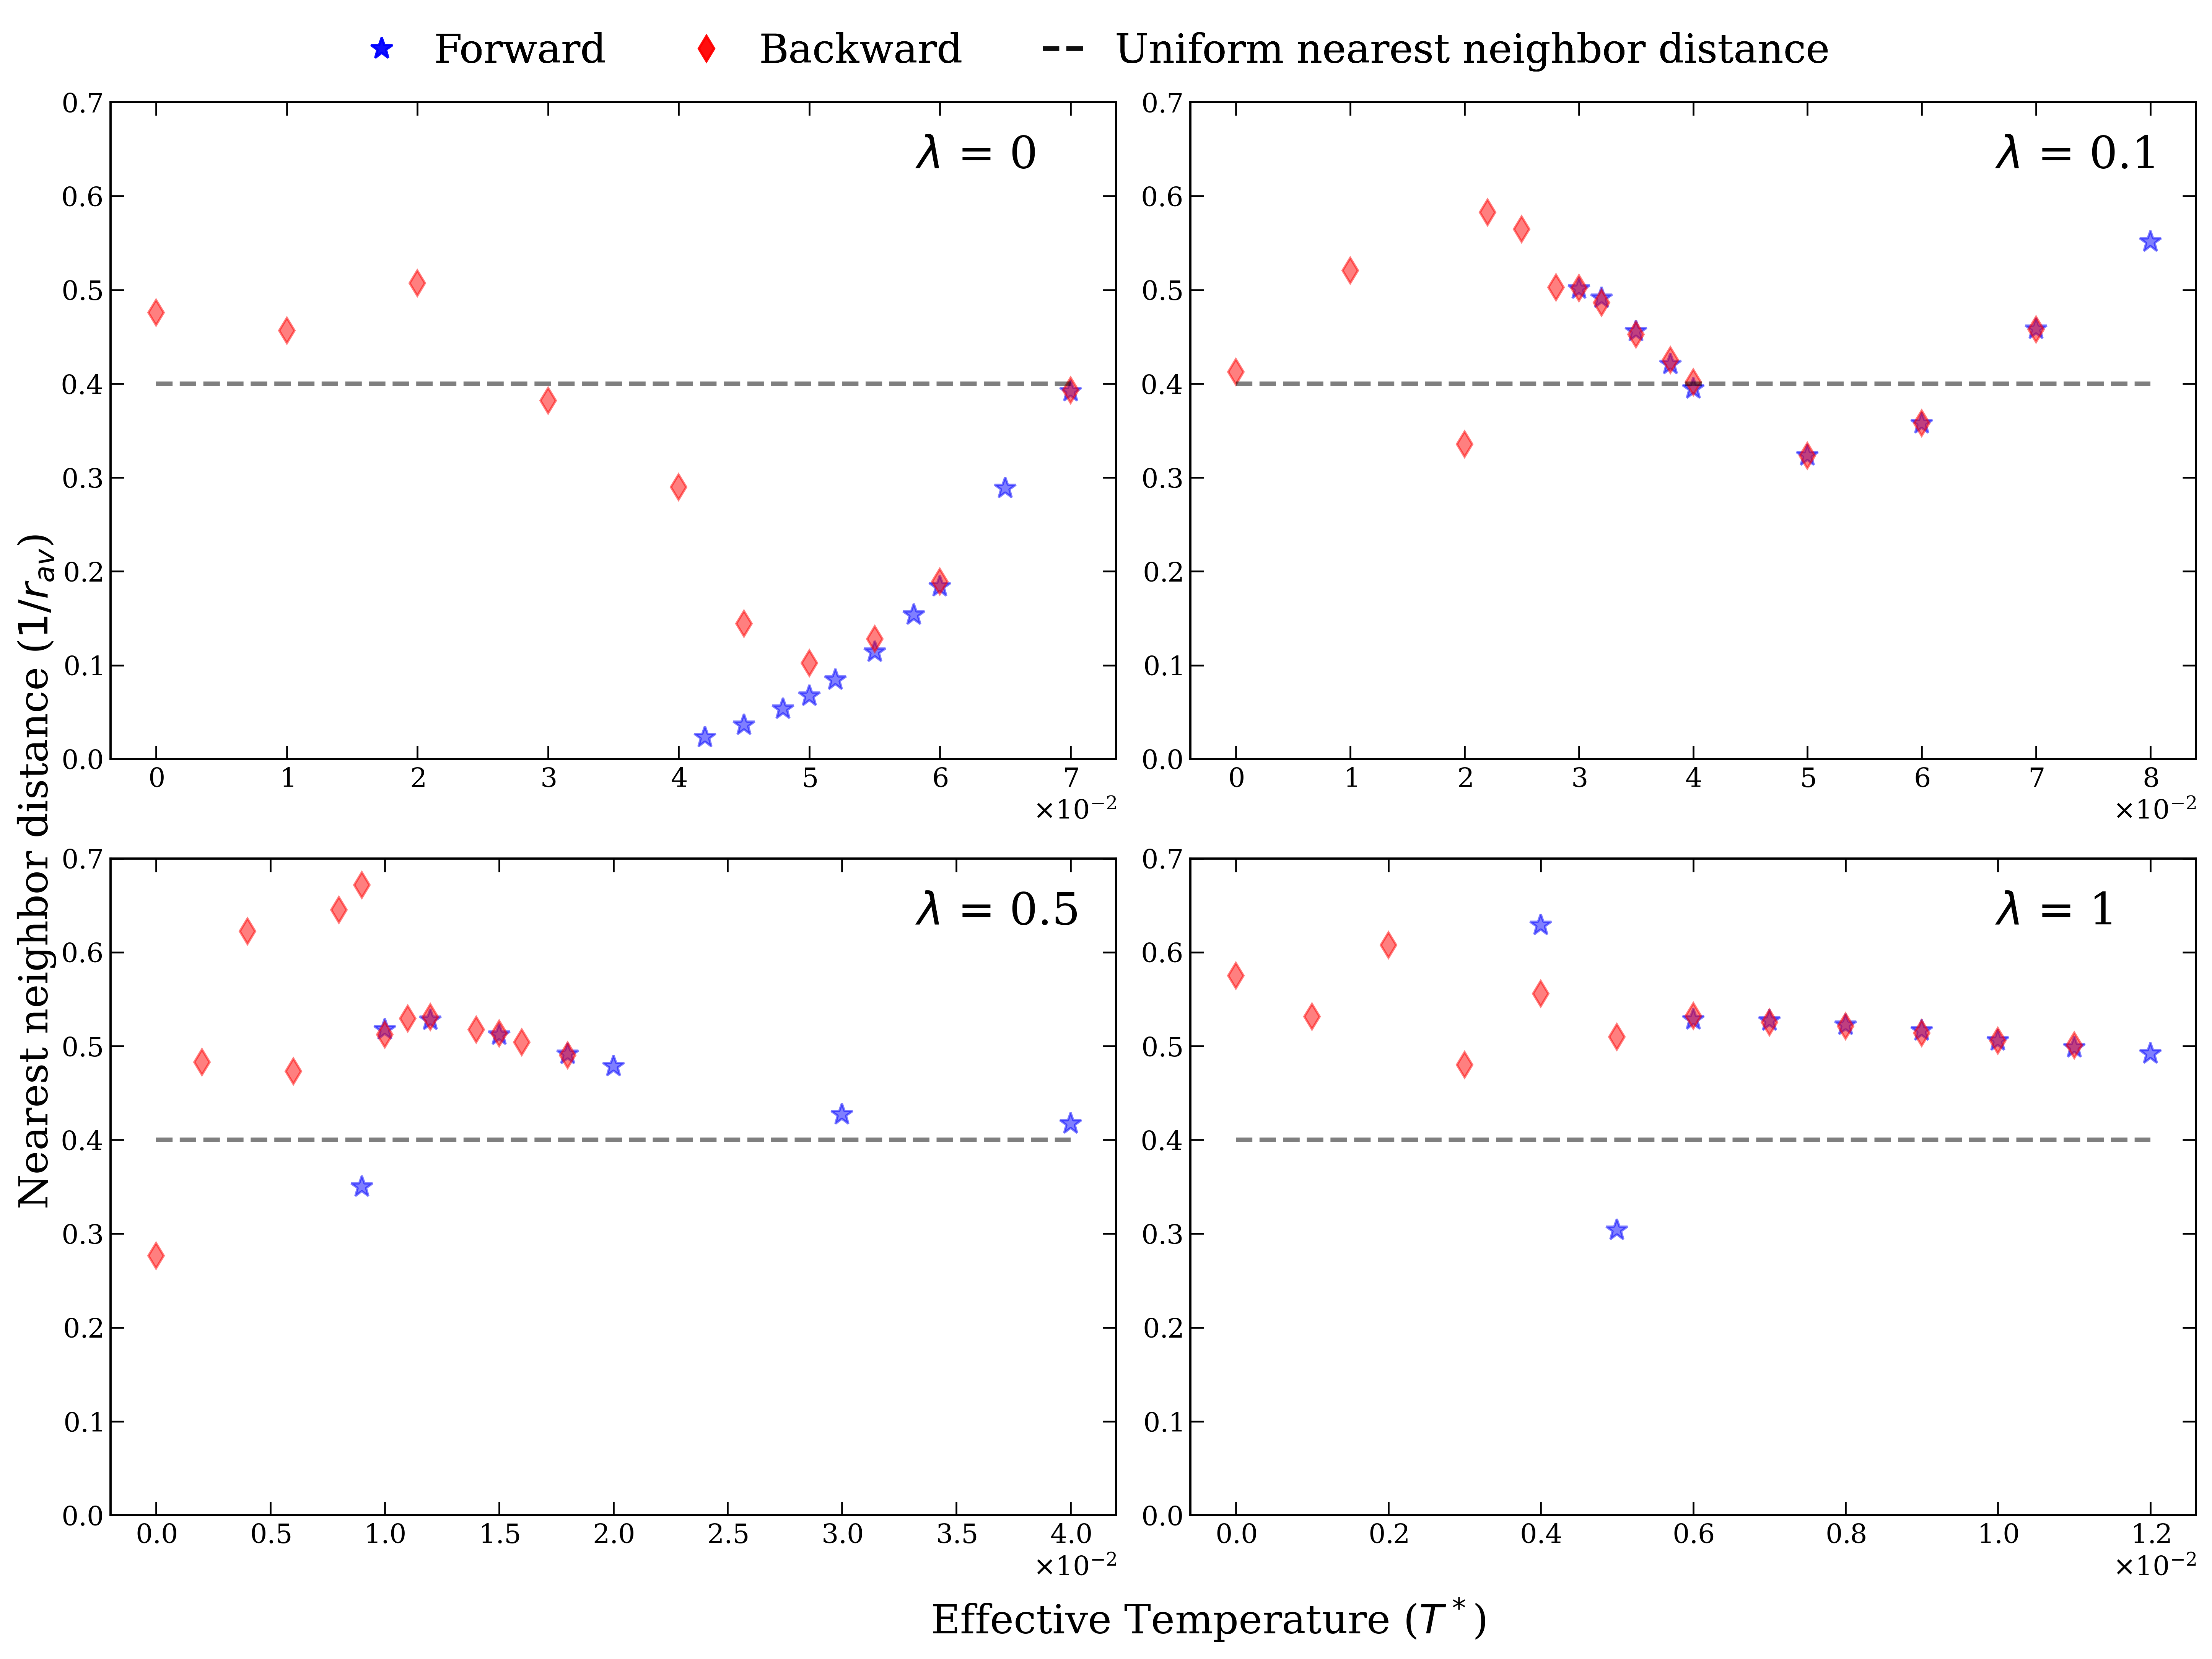

In [313]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(14, 10))
ax = ax.flatten()
nmin_samples=20

normalize=True
for i, lambda_val in enumerate([0, .1, .5, 1]):
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))

    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))

    nn_arr_fwd_av = np.nan * np.zeros((len(act_fwd)))
    nn_arr_fwd_weighted_av = np.nan * np.zeros((len(act_fwd),2))

    nn_arr_bck_av = np.nan * np.zeros((len(act_bck)))
    nn_arr_bck_weighted_av = np.nan * np.zeros((len(act_bck),2))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for j in range(len(act_fwd)):
            ff_idx = int(conv_list_fwd[j])
            normalizer = LX / np.sqrt(def_arr_fwd[ff_idx:,j]) if normalize else 1
            
            if (nn_arr_fwd[:,0,j] > 0).sum() >=  nmin_samples:
                nn_arr_fwd_av[j] = np.nanmean(nn_arr_fwd[ff_idx:,0,j] / normalizer)
                nn_arr_fwd_weighted_av[j] = calc_weighted_mean_vec(nn_arr_fwd[ff_idx:,0,j] / normalizer, 
                                                                nn_arr_fwd[ff_idx:,1,j] / normalizer)[:2]
        for j in range(len(act_bck)):
            ff_idx = int(conv_list_bck[j])
            normalizer = LX / np.sqrt(def_arr_bck[ff_idx:,j]) if normalize else 1
            
            if (nn_arr_bck[:,0,j] > 0).sum() >=  nmin_samples:
                nn_arr_bck_av[j] = np.nanmean(nn_arr_bck[ff_idx:,0,j] / normalizer)
                nn_arr_bck_weighted_av[j,] = calc_weighted_mean_vec(nn_arr_bck[ff_idx:,0,j] / normalizer,
                                                                nn_arr_bck[ff_idx:,1,j] / normalizer)[:2]

    ax[i].plot(act_fwd, nn_arr_fwd_av, 'b*',alpha=.5,ms=10, label=rf'Forward' if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
    ax[i].plot(act_bck, nn_arr_bck_av, 'rd',alpha=.5, ms=8, label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')
    
    #ax[i].errorbar(act_fwd, nn_arr_fwd_weighted_av[:,0], yerr=nn_arr_fwd_weighted_av[:,1], alpha=.5,ms=10,fmt='b*-', label=rf'Forward' if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
    #ax[i].errorbar(act_bck, nn_arr_bck_weighted_av[:,0], yerr=nn_arr_bck_weighted_av[:,1], alpha=.5, ms=10,fmt='rd-', label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')

    #ax[i].errorbar(act_fwd, rel_diff_fwd_av[:len(act_fwd)], yerr=rel_diff_fwd_std[:len(act_fwd)], alpha=.5,ms=10,fmt='b*-', label=rf'Forward' if i==0 else None)#$\lambda = $ {lambda_val}')# label=r'$\overline{l_{max}}$')
    #ax[i].errorbar(act_bck, rel_diff_bck_av[:len(act_bck)], yerr=rel_diff_bck_std[:len(act_bck)], alpha=.5, ms=10,fmt='rd-', label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    #ax[i].legend()
    #ax[1].legend()  
    #ax[0].set_title('Forward')
    #ax[1].set_title('Backward')
    ax[i].set_ylim([0, 0.7])
    ax[i].hlines(0.4, 0, max(act_fwd[-1], act_bck[-1]), linestyle='--', color='black', alpha=0.5,
                 label='Uniform nearest neighbor distance' if i==0 else None) 
    #ax[i].set_ylim(ymax=0.43 if i==0 else .1)
    #ax[0].set_xlim(xmin=0,xmax=.082)
    #ax[1].set_xlim(xmin=0,xmax=.082)

    fig.supylabel(r'Nearest neighbor distance ($1/r_{av}$)')
    #ax[i].text(0.8, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    #fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045))
    fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.02)
    fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045), handlelength=1)
    #    .set_xlabel(r'Effective Temperature ($T^*$)')
    save_path = os.path.join(out_path_all, 'figs')
    fig.tight_layout()
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    fig.savefig(os.path.join(save_path, f'nn_av.png'), bbox_inches='tight', pad_inches=.1) 

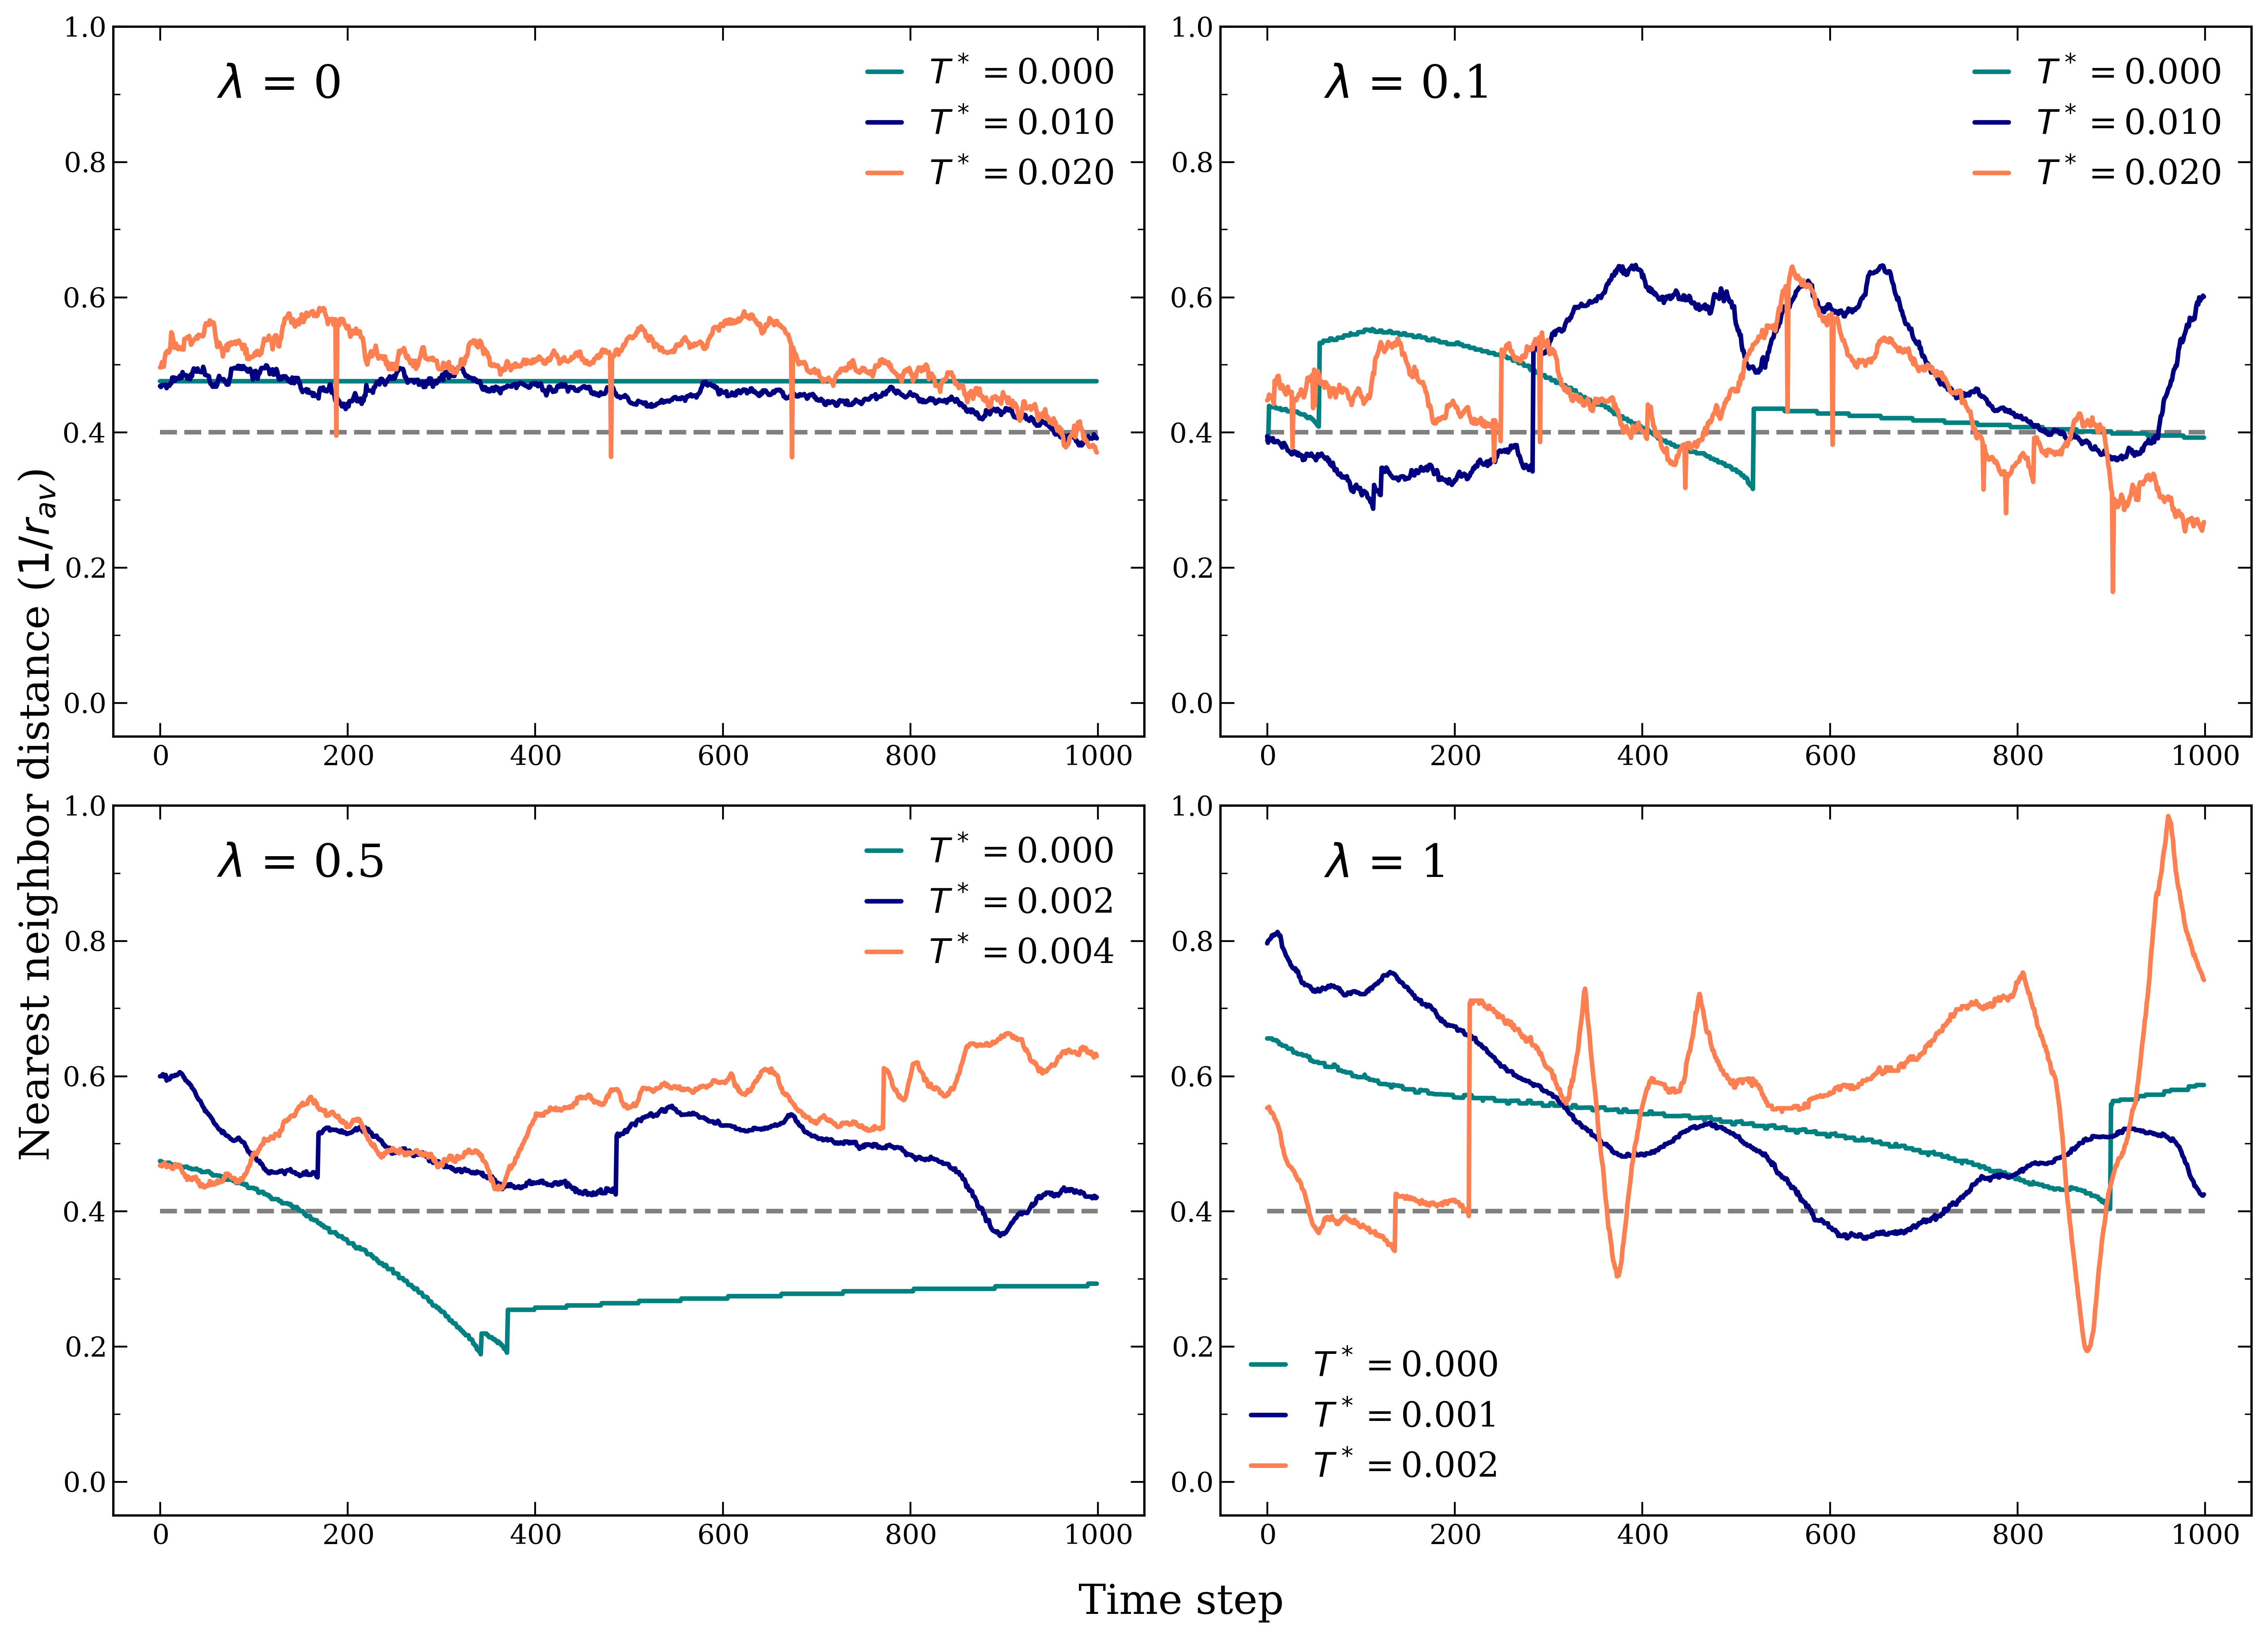

In [386]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(14, 10))
ax = ax.flatten()
normalize=True
for i, lambda_val in enumerate([0,.1,.5,1]):
    normalizer = LX if normalize else 1
    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
    conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    lmax_arr_fwd = np.load(os.path.join(out_path_fwd, 'lmax_arr.npy'))
    lmax_arr_bck = np.load(os.path.join(out_path_bck, 'lmax_arr.npy'))

    
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax[i].set_ylim([-0.05,1])
    #ax[i].errorbar(act_bck, rel_diff_bck_av[:len(act_bck)], yerr=rel_diff_bck_std[:len(act_bck)], alpha=.5, ms=10,fmt='rd-', label=rf'Backward' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].text(0.1, 0.9, rf'$\lambda$ = {lambda_val}', transform=ax[i].transAxes, color='black',fontsize=20)
    ax[i].hlines(0.4, 0, 1000, linestyle='--', color='black', alpha=0.5,)
                 #label='Uniform nearest neighbor distance' if i==0 else None) 
    

    for j, T in enumerate(act_bck[:3]):
        mask_bck = nn_arr_bck[:,0, j] > 0
        normalizer = LX / np.sqrt(def_arr_bck[mask_bck,j]) if normalize else 1

        if mask_bck.sum() < 20: continue

   #     ax[i].errorbar(np.arange(Nframes)[mask_bck], nn_arr_bck[mask_bck,0,j] / normalizer, nn_arr_bck[mask_bck,1,j] / normalizer,label = rf'$T^* = ${T:.4f}')
        #ax[i].plot(np.arange(Nframes)[mask_bck], lmax_arr_bck[mask_bck,j] / normalizer, label = rf'$T^* = ${T:.4f}')
        ax[i].plot(np.arange(Nframes)[mask_bck], nn_arr_bck[mask_bck, 0, j] / normalizer, label = rf'$T^* = ${T:.3f}')
    ax[i].legend(handlelength=1)

fig.supylabel(r'Nearest neighbor distance ($1/r_{av}$)')
fig.supxlabel('Time step', x=.525)
#ax.set_ylim(ymax=20)
#fig.legend(loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.045))
#fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

fig.savefig(os.path.join(save_path, f'nn_over_time.png')) 

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13536\3601484261.py:6: RuntimeWarning: divide by zero encountered in divide
  normalizer = LX / np.sqrt(def_arr_fwd[:,i]) if normalize else 1


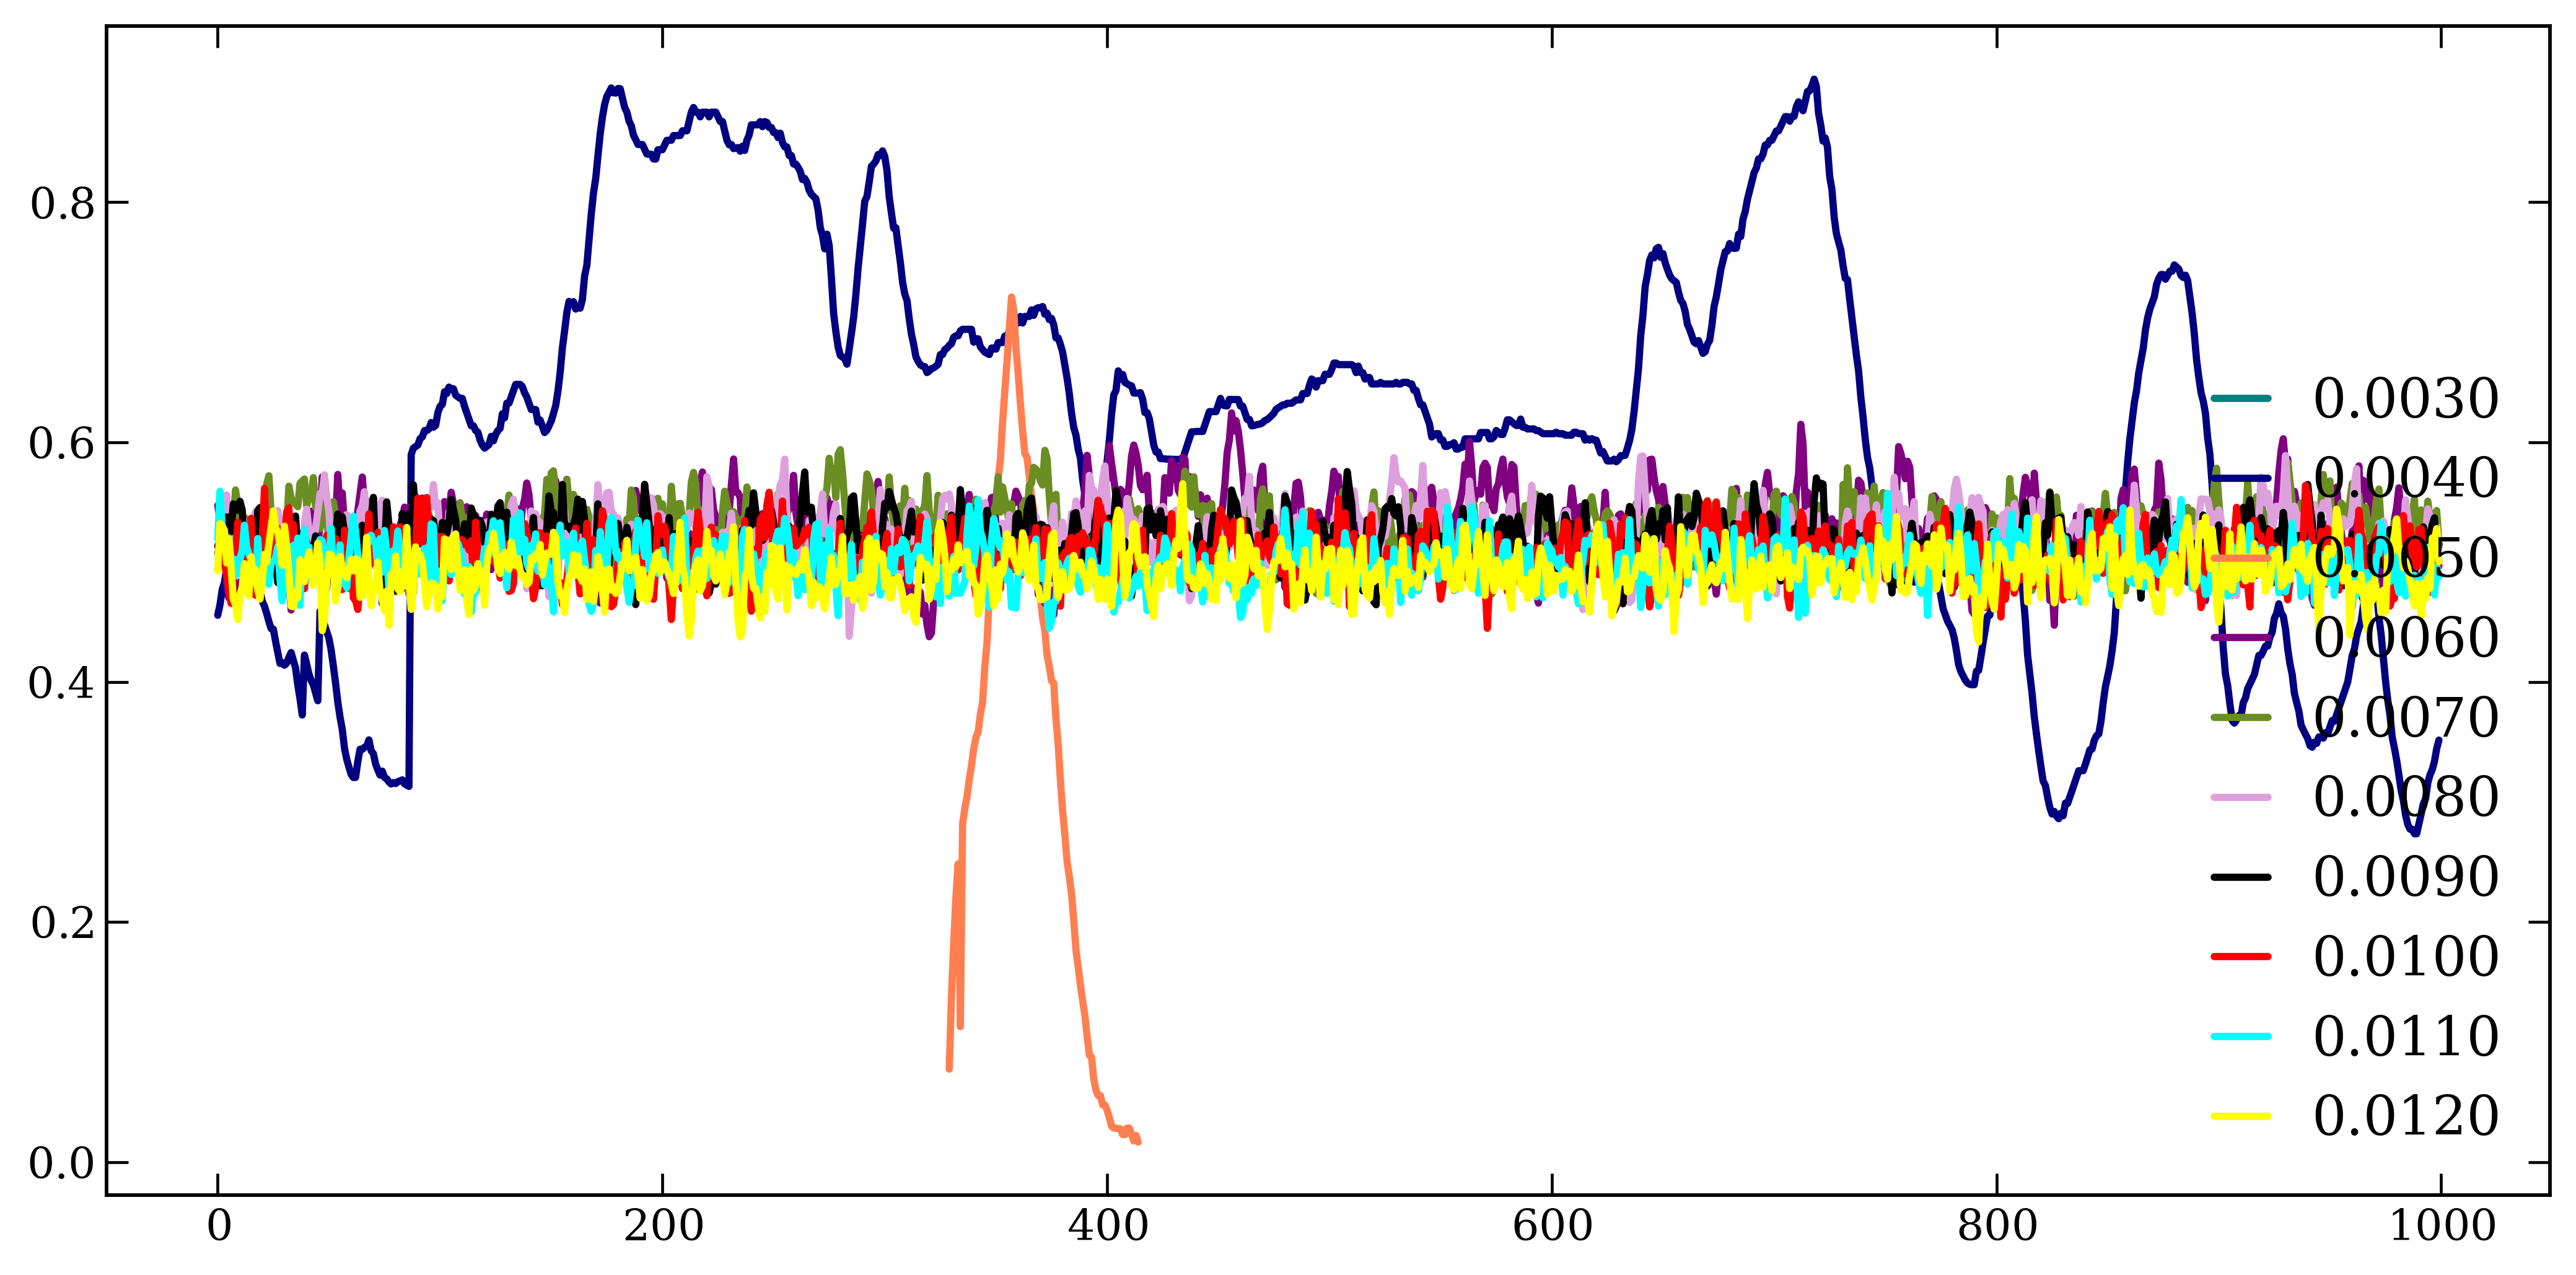

In [254]:
fig, ax = plt.subplots(figsize=(10, 5))
normalize = True
#normalizer = def_arr_fwd

for i in range(10):
    normalizer = LX / np.sqrt(def_arr_fwd[:,i]) if normalize else 1
    ax.plot(np.arange(Nframes), nn_arr_fwd[:,0,i] / normalizer, label = f'{act_fwd[i]:.4f}')
    #ax.errorbar(np.arange(Nframes), nn_arr_fwd[:,0,i] ,nn_arr_fwd[:,1,i], label = f'{act_fwd[i]:.4f}')
ax.legend(handlelength=1)
#ax.set_ylim(ymax=20)

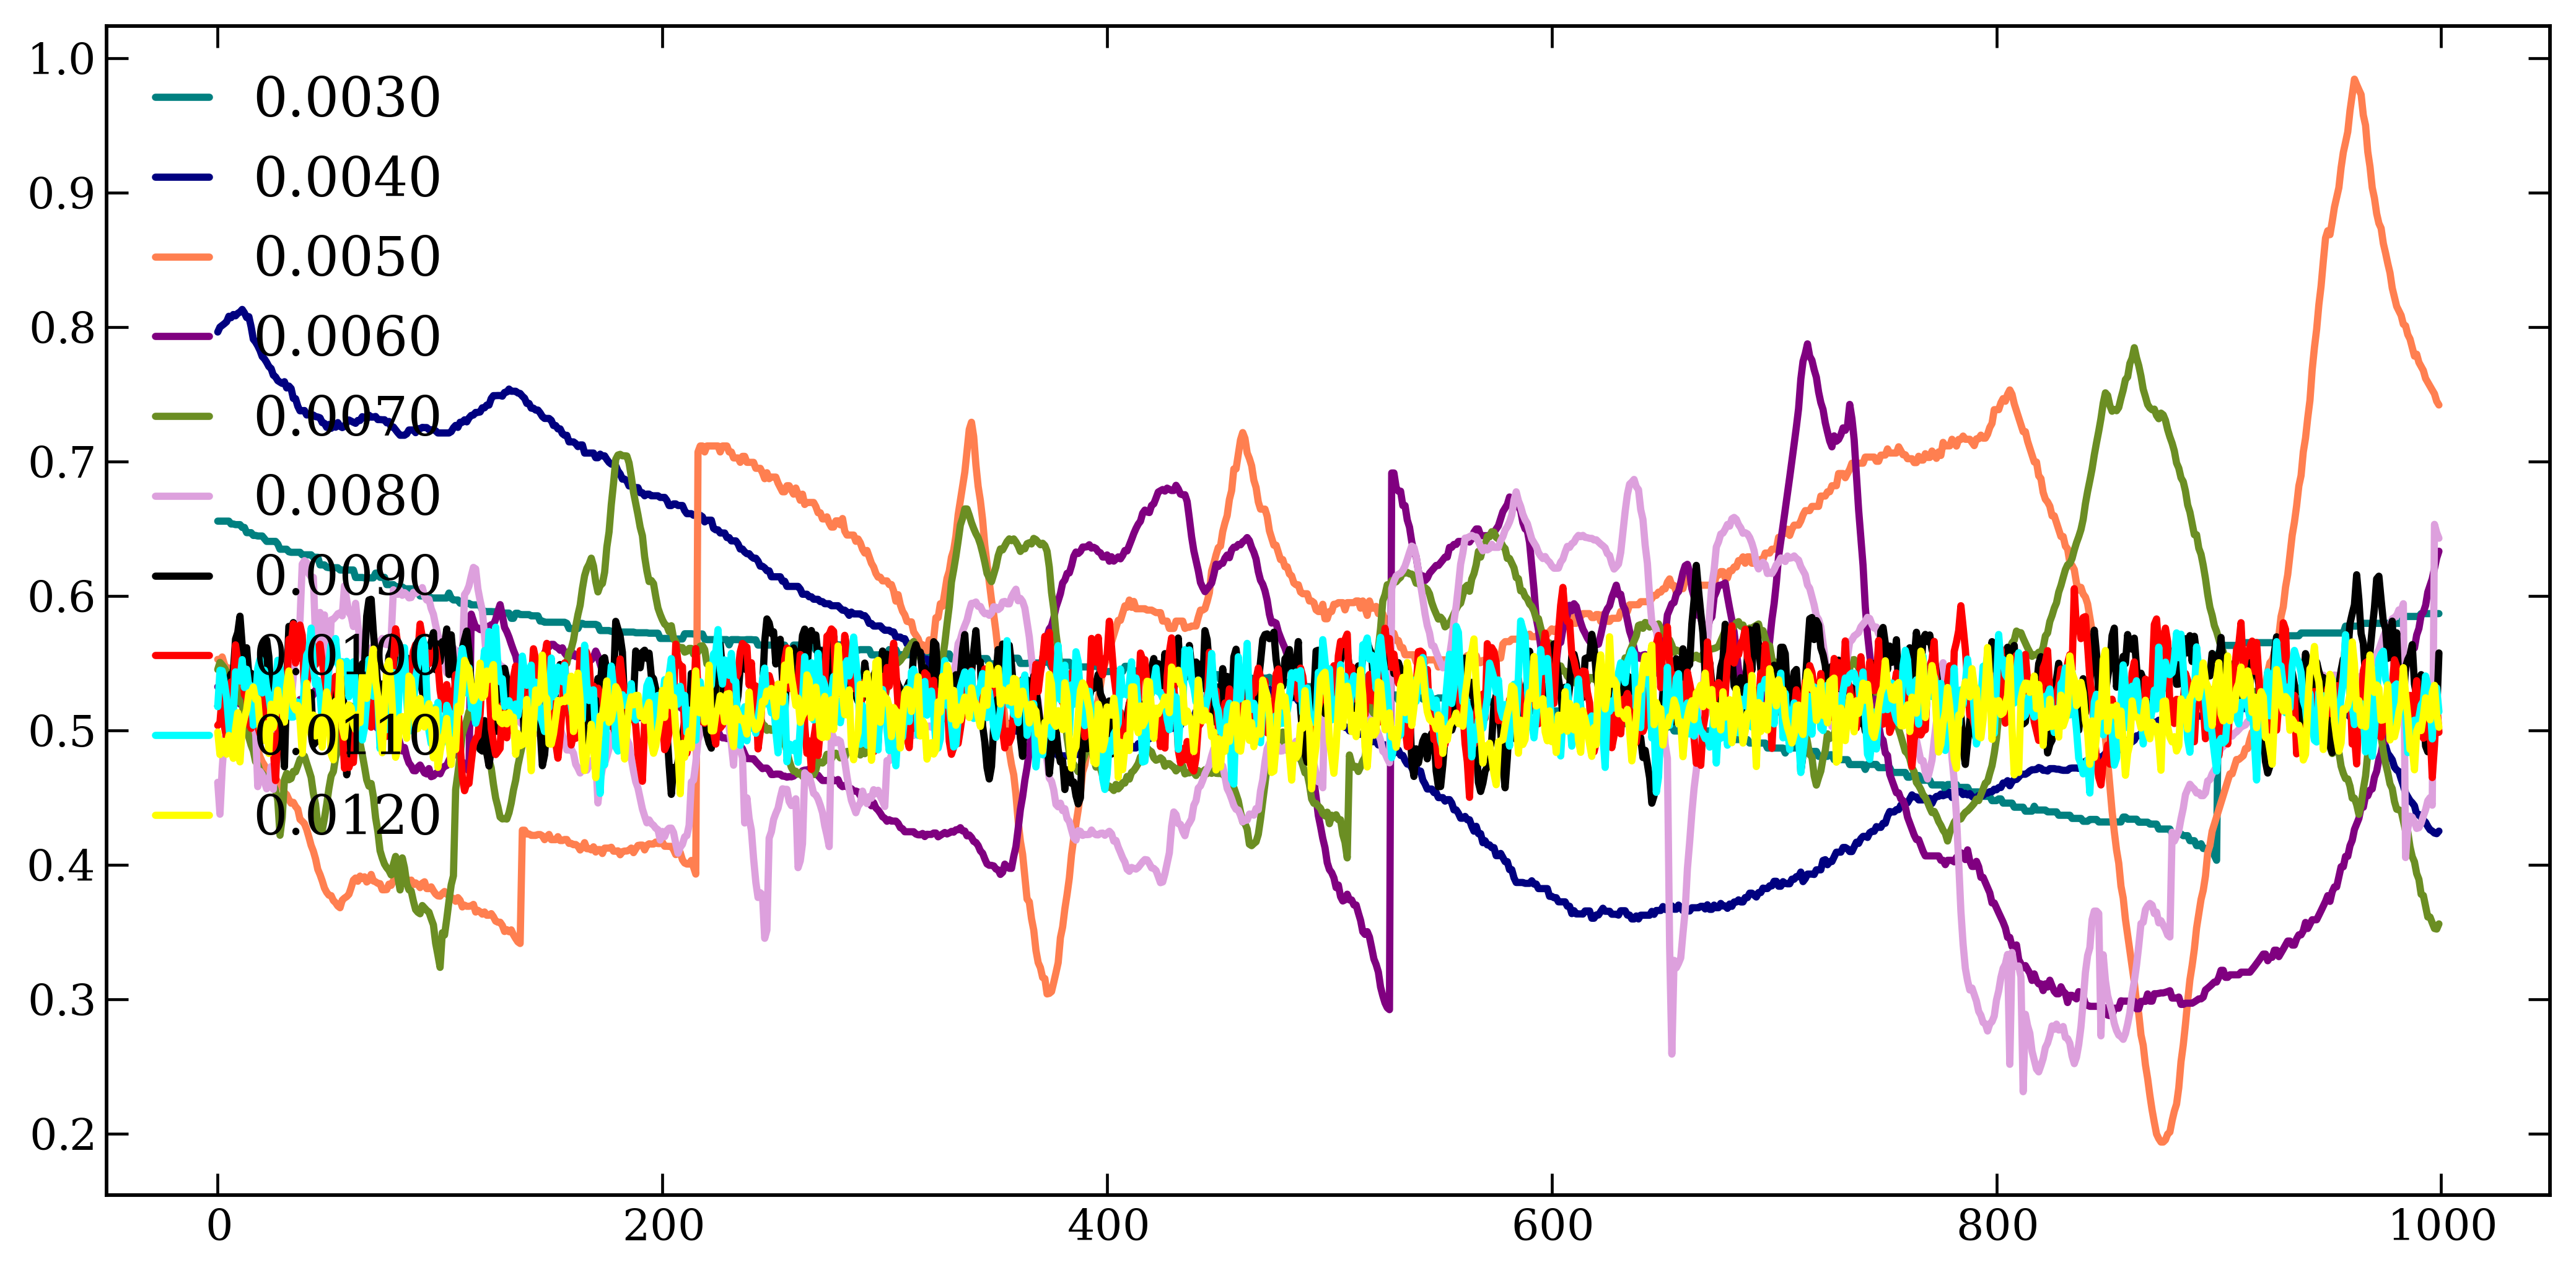

In [314]:
fig, ax = plt.subplots(figsize=(10, 5))
normalize = True
#normalizer = def_arr_fwd

for i in range(10):
    normalizer = LX / np.sqrt(def_arr_bck[:,i]) if normalize else 1
    ax.plot(np.arange(Nframes), nn_arr_bck[:,0,i] / normalizer, label = f'{act_fwd[i]:.4f}')
    #ax.errorbar(np.arange(Nframes), nn_arr_fwd[:,0,i] ,nn_arr_fwd[:,1,i], label = f'{act_fwd[i]:.4f}')
ax.legend(handlelength=1)
#ax.set_ylim(ymax=20)

## Total charge is not generally 0. This must be accounted for

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax = ax.flatten()
for i, act in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])
    vals = qmax_arr_fwd[ff_idx:, i].flatten() #/ (av_def[i,0] )  

   # print(act, (vals==0).sum(), (qmax_arr_fwd[:, i].flatten()==0).sum())

    ax[0].hist(vals[~np.isnan(vals)], bins = 20, alpha = .5, label = act, density=True)
    ax[0].title.set_text('Forward') 
for i, act in enumerate(act_bck):
    if act in []:
        continue
    ff_idx = int(conv_list_bck[i])
    vals = qmax_arr_bck[ff_idx:, i].flatten() #/ (av_def[i,0] ) 
 ##   print() 
   # print(act, (vals==0).sum(), (qmax_arr_bck[:, i].flatten()==0).sum())
    ax[1].hist(vals[~np.isnan(vals)], bins = 40, alpha = .5, label = act, density=True)
    ax[1].title.set_text('Backward')
ax[0].legend()
ax[1].legend()
fig.supylabel('Density')
fig.supxlabel('Absolute value of total charge')

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qmax_hist_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

act_max = 0.18
act_max_res = 0.18

for i, act in enumerate(act_fwd):
    if act in [.007,.011]:
        continue
    if act > act_max:
        continue

    max_idx = np.argwhere(qfilter_fwd[i,:,0] - qfilter_fwd[i,:,1]<=0)[0][0] #int(np.max(idx_arr_fwd[ff_idx, i,]))
    ax[0].errorbar(rmax_list[:max_idx], qfilter_fwd[i,:max_idx,0], qfilter_fwd[i,:max_idx,1], label=f'{act}', alpha=.3)
    ax[0].title.set_text('Forward')



for i, act in enumerate(act_bck):
    if act in [0.007,.008]:
        continue
    if act > act_max:
        continue

    max_idx = np.argwhere(qfilter_bck[i,:,0] - qfilter_bck[i,:,1]<=0)[0][0] #int(np.max(idx_arr_fwd[ff_idx, i,]))
    ax[1].errorbar(rmax_list[:max_idx], qfilter_bck[i,:max_idx,0], qfilter_bck[i,:max_idx,1], label=f'{act}', alpha=.3)
    ax[1].title.set_text('Backward')


for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$r_{\max}$')
    a.set_ylabel(r'$Q_{\mathrm{cl}}$ (filtered)')
    a.legend(ncols=3, fontsize=8)

ax[0].set_xlim(xmin=10, xmax=150)
ax[1].set_xlim(xmin=10, xmax=300)  
ax[0].set_ylim([0, .4])
ax[1].set_ylim([0, .6])    
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qcl_filtered_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

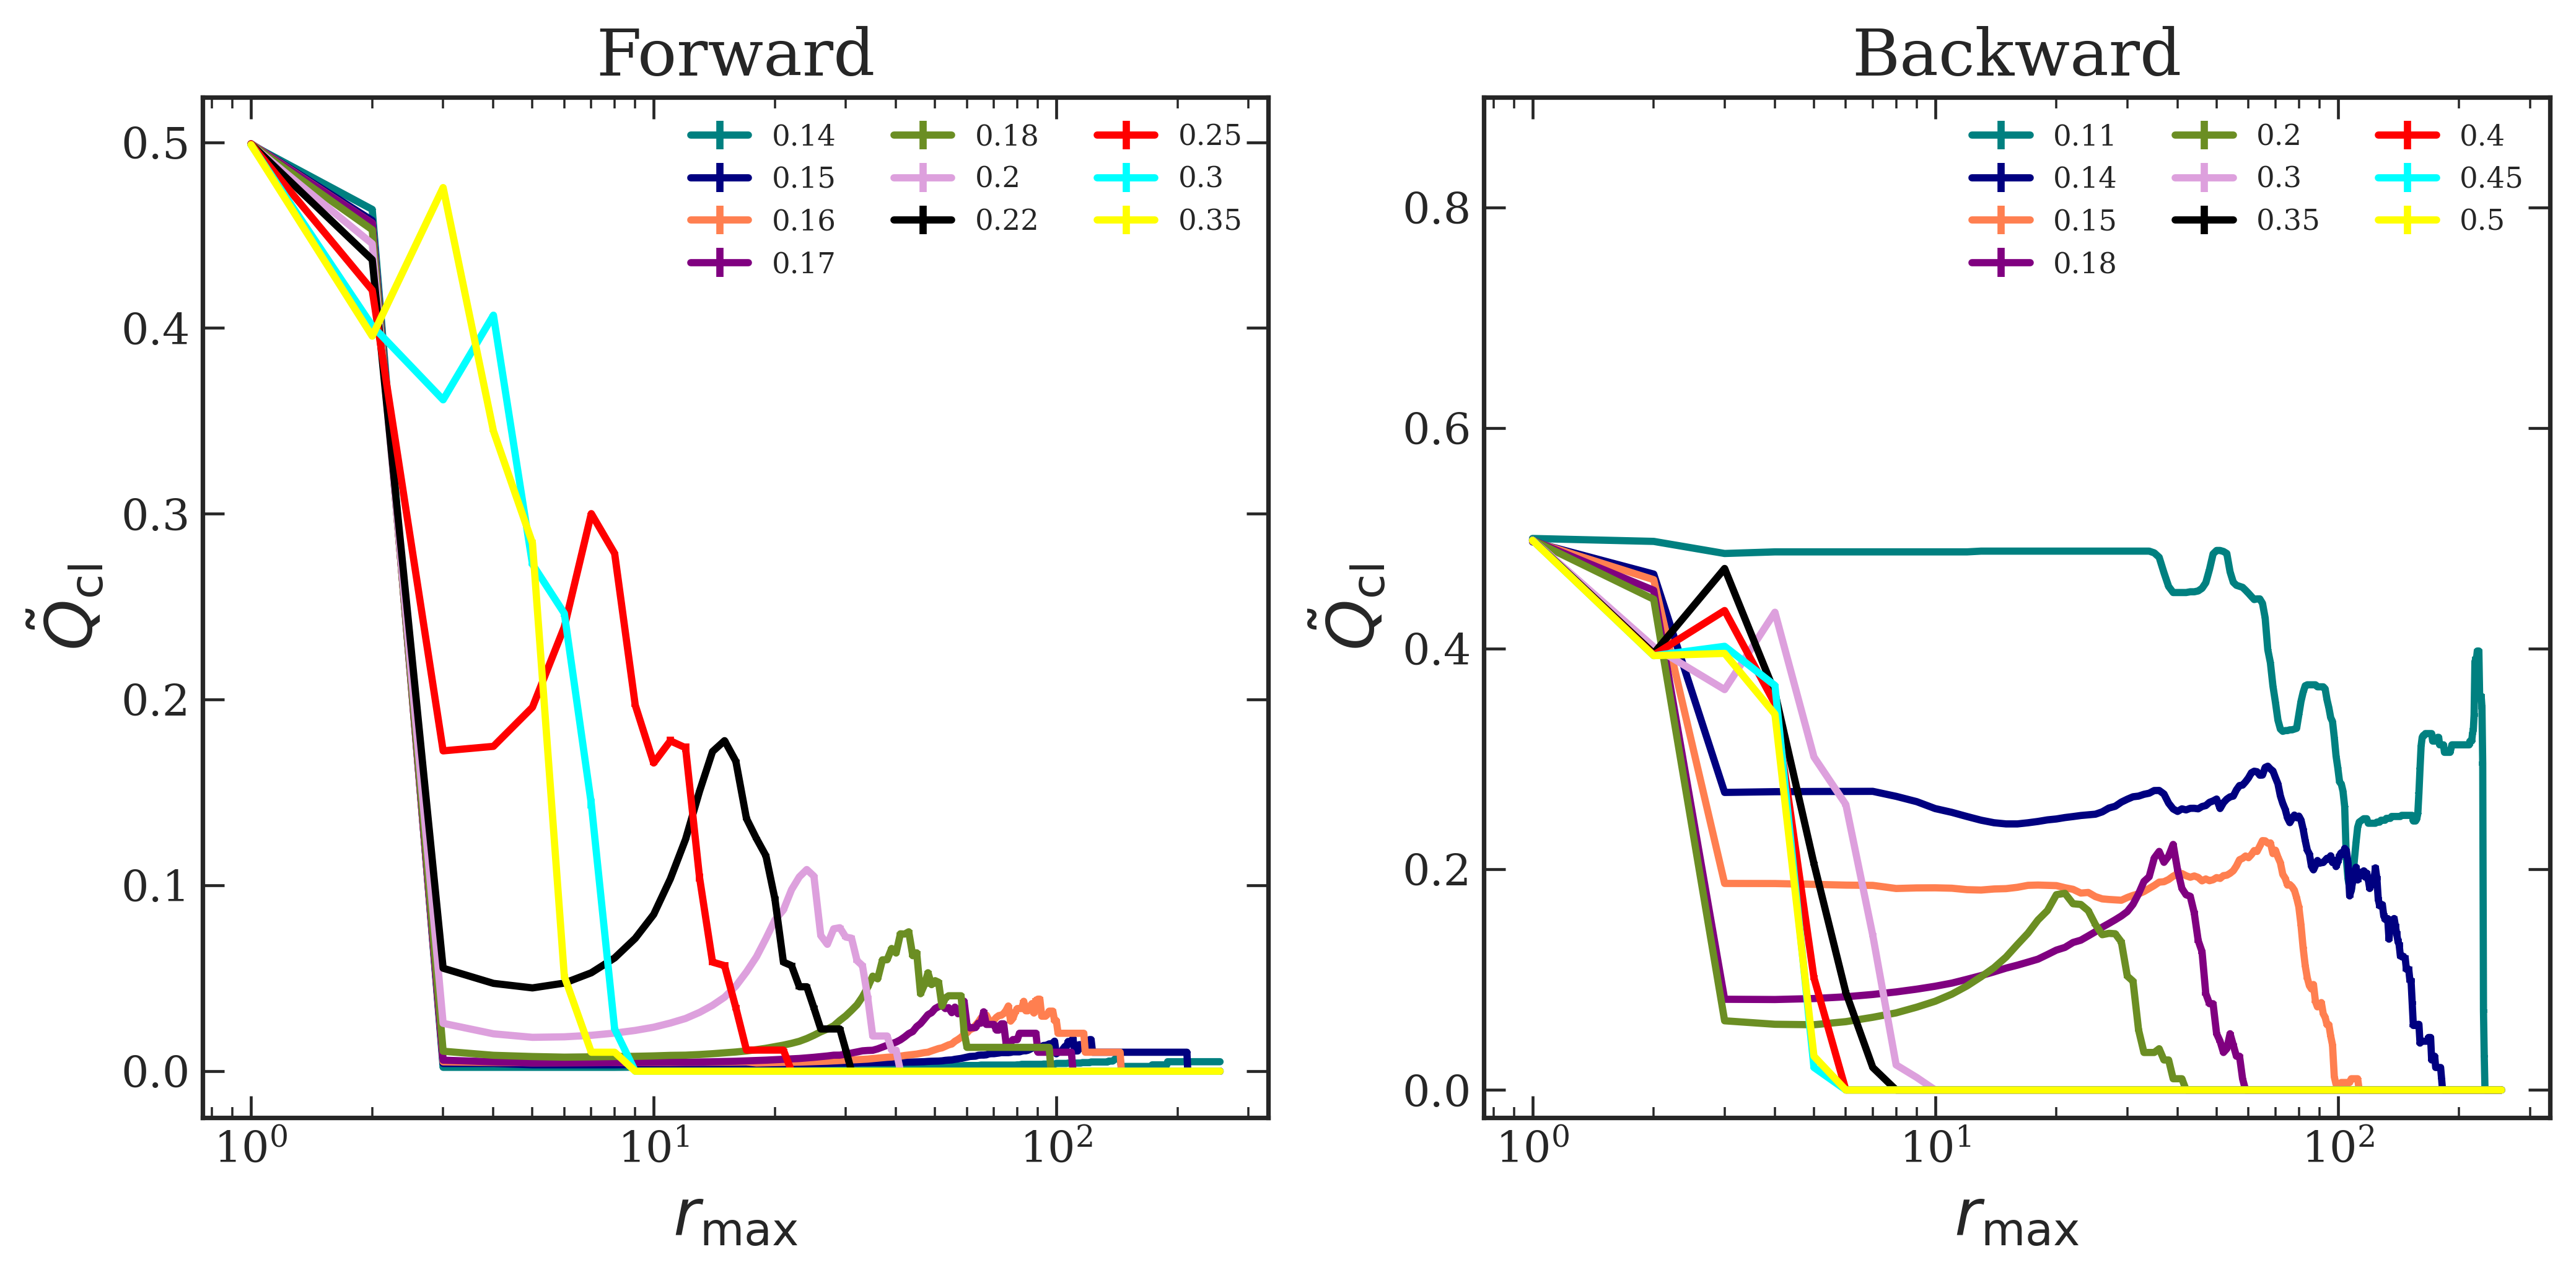

In [368]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


for i, act in enumerate(act_fwd):
    if act in act_exclude_fwd:
        continue
    if act in [.011, .009]:
        continue

    ff_idx = int(conv_list_fwd[i])
    vals = qarr_shifted_fwd[ff_idx:, :, i,]

    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[0].errorbar(rmax_list[:], qav, qstd, label=f'{act}')
    ax[0].title.set_text('Forward')

for i, act in enumerate(act_bck):
    if act in act_exclude_bck:
        continue
    if mode == 'dry' and act in [.25, .16, .13, .12, .17]:
        continue
    if mode == 'wet' and act in [.009, .011, .002, .005]:
        continue

    ff_idx = int(conv_list_bck[i])
    vals = qarr_shifted_bck[ff_idx:, :, i,]

    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[1].errorbar(rmax_list[:], qav, qstd, label=f'{act}')
    ax[1].title.set_text('Backward')

for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$r_{\max}$')
    a.set_ylabel(r'$\tilde{Q}_{\mathrm{cl}}$')
    a.legend(ncols=3, fontsize=8)

ax[1].set_ylim(ymax=.9)

fig.tight_layout()
if save_figs:
    fig.savefig(os.path.join(fig_path, f'qcl_shift_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

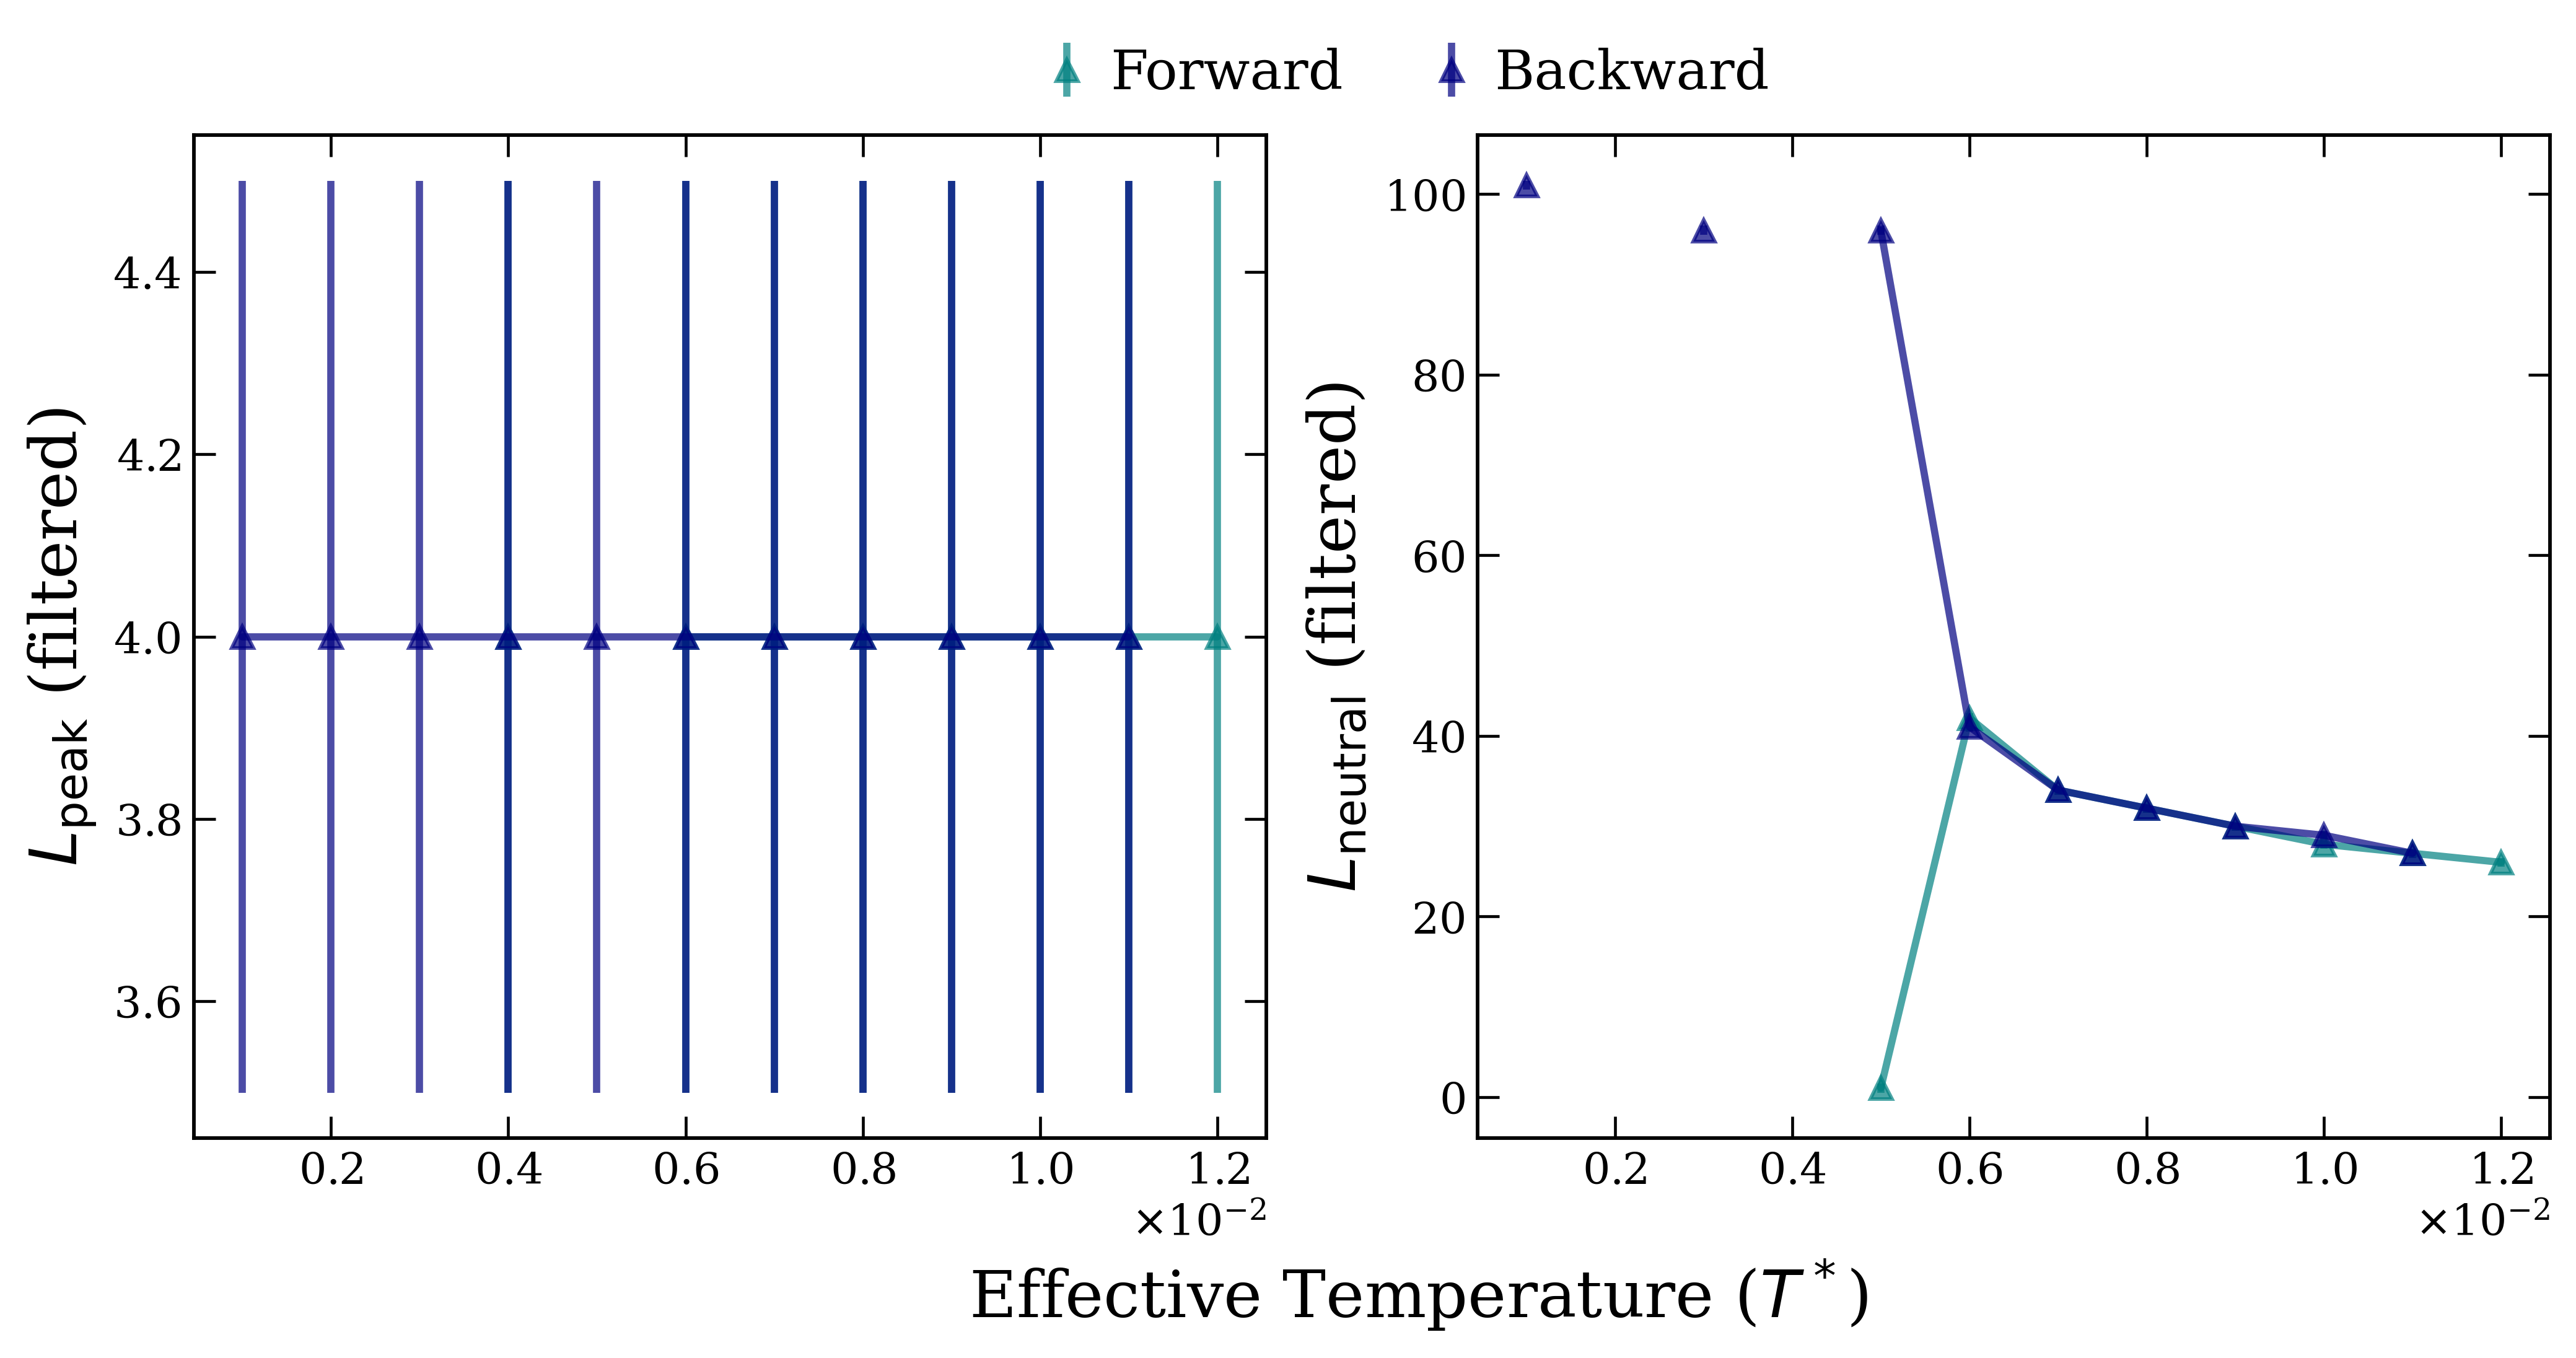

In [130]:
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))

ax[0].errorbar(act_fwd, qpeak_filter_fwd[:, 0], yerr = qpeak_filter_fwd[:, 1],  fmt = '^-', alpha=.7, label = 'Forward')
ax[0].errorbar(act_bck, qpeak_filter_bck[:, 0], yerr = qpeak_filter_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
ax[0].set_ylabel(r'$L_{\mathrm{peak}}$ (filtered)')


ax[1].errorbar(act_fwd, lneutral_filter_fwd[:, 0], yerr = lneutral_filter_fwd[:, 1], fmt = '^-', alpha=.7)
ax[1].errorbar(act_bck, lneutral_filter_bck[:, 0], yerr = lneutral_filter_bck[:, 1], fmt = '^-', alpha=.7)
ax[1].set_ylabel(r'$L_{\mathrm{neutral}}$ (filtered)')

if mode == 'dry':
    ax[1].vlines(0.15, 0, 200, linestyle = '--', lw=1.5, color = 'k')
    ax[1].fill_betweenx([0,200], 0.145, 0.155, color = 'blue', alpha = 0.3)
    ax[1].text(0.16, 170, r'$T^{pf}_{\mathrm{KT}}(L_{\mathrm{neutral}}) \approx 0.15$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, f'qpeak_filtered_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

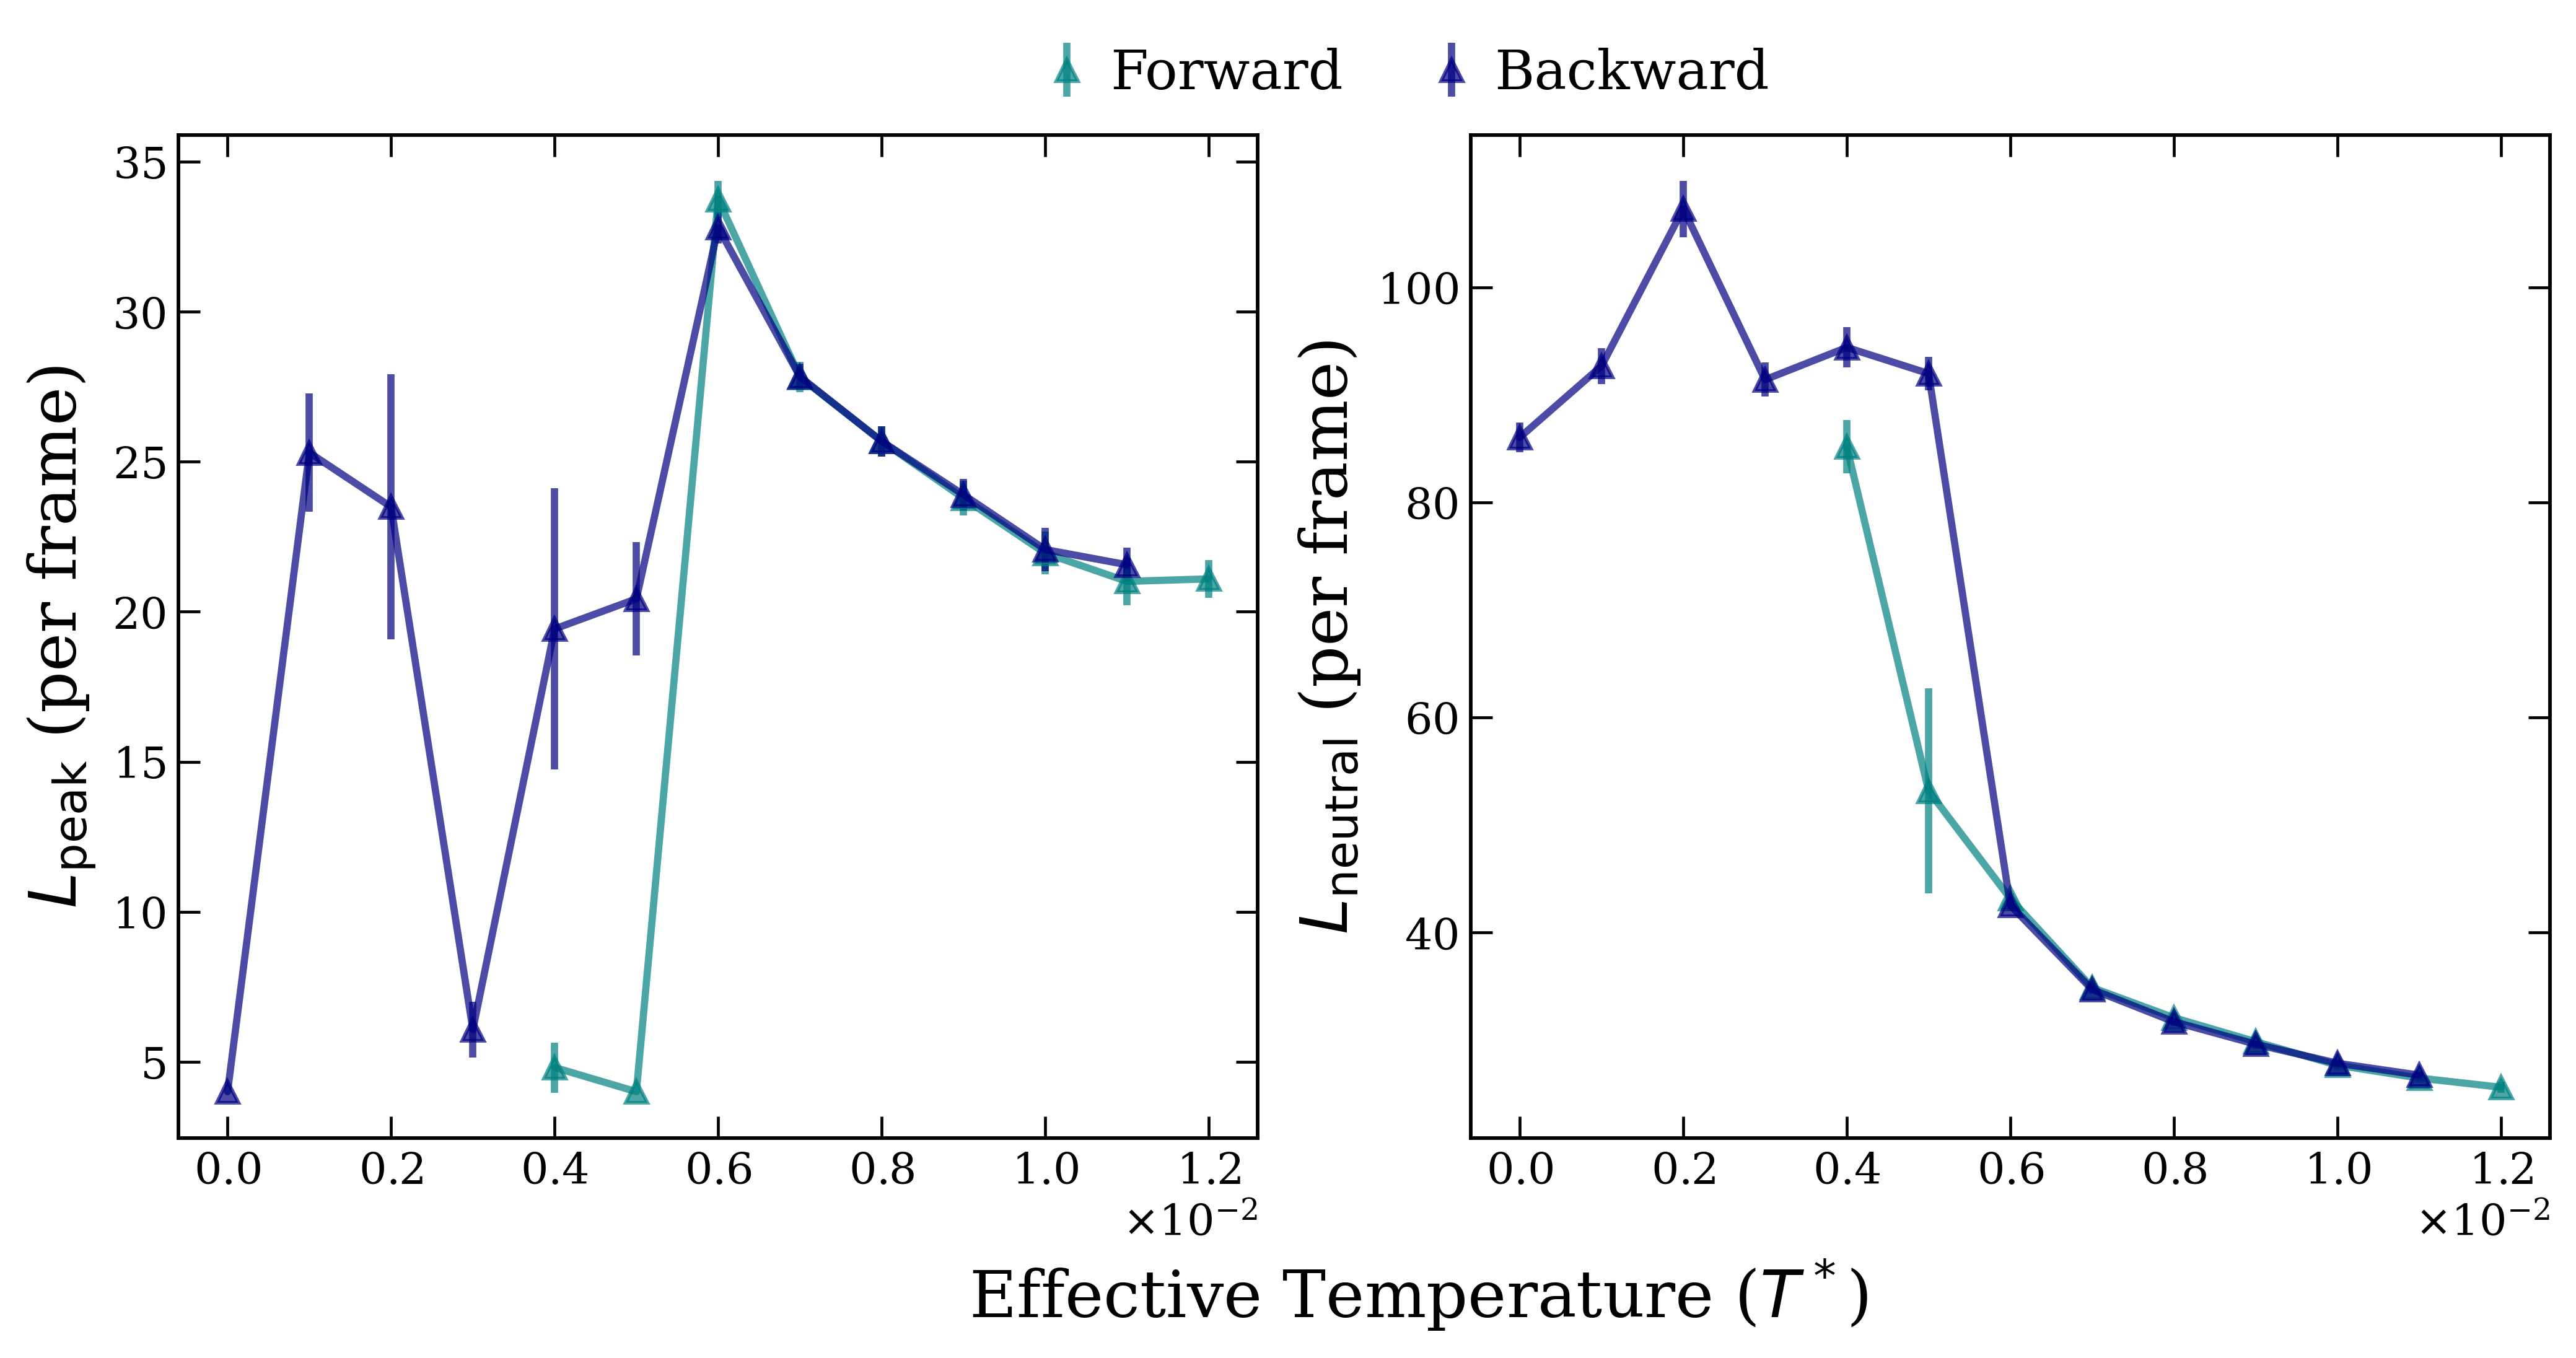

In [117]:
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))

ax[0].errorbar(act_fwd, qpeak_per_frame_fwd[:, 0], yerr = qpeak_per_frame_fwd[:, 1],  fmt = '^-', alpha=.7, label = 'Forward')
ax[0].errorbar(act_bck, qpeak_per_frame_bck[:, 0], yerr = qpeak_per_frame_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
ax[0].set_ylabel(r'$L_{\mathrm{peak}}$ (per frame)')

ax[1].errorbar(act_fwd, lneutral_per_frame_fwd[:, 0], yerr = lneutral_per_frame_fwd[:, 1], fmt = '^-', alpha=.7)
ax[1].errorbar(act_bck, lneutral_per_frame_bck[:, 0], yerr = lneutral_per_frame_bck[:, 1], fmt = '^-', alpha=.7)
ax[1].set_ylabel(r'$L_{\mathrm{neutral}}$ (per frame)')

if mode == 'dry':
    ax[1].vlines(0.175, 0, 200, linestyle = '--', lw=1.5, color = 'k')
    ax[1].fill_betweenx([0,200], 0.16, 0.19, color = 'blue', alpha = 0.3)
    ax[1].text(0.2, 170, r'$T^{filtered}_{\mathrm{KT}}(L_{\mathrm{neutral}}) \approx 0.175$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout()

if save_figs:
    pass
    #fig.savefig(os.path.join(fig_path, f'qpeak_lneutral_per_frame_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

_filter
_filter
_filter
_filter


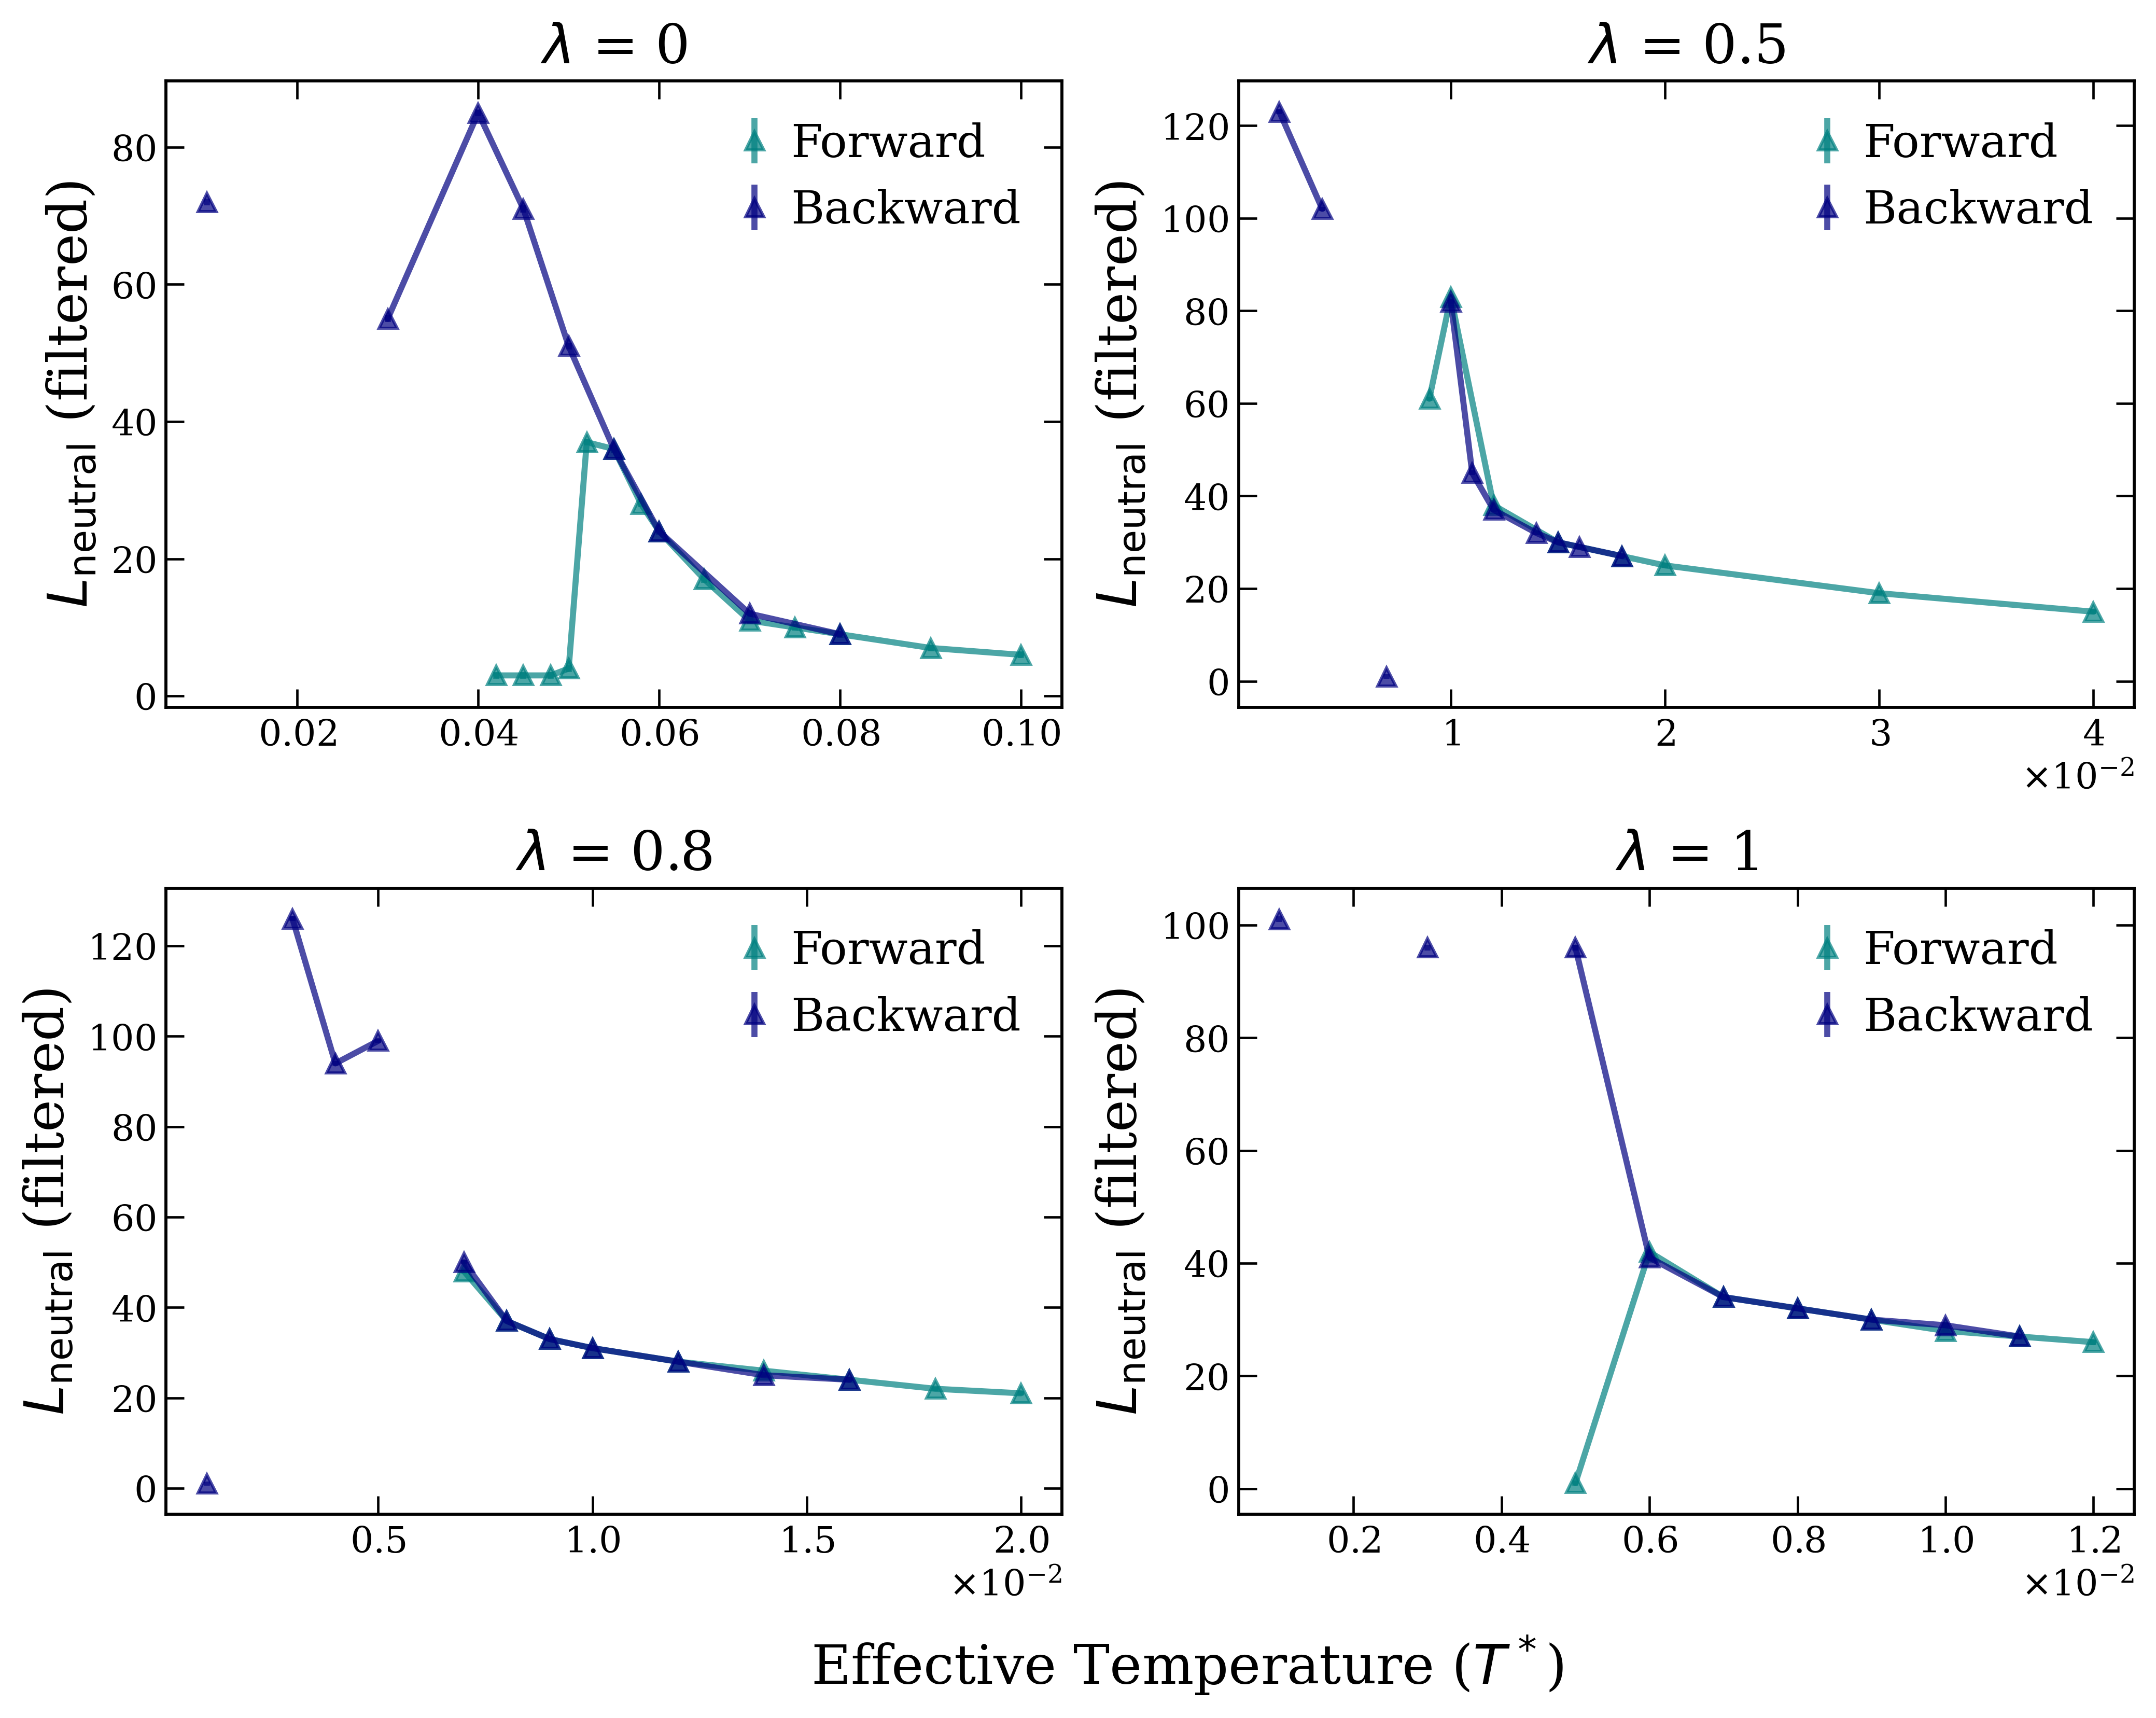

In [25]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize = (10, 8))
ax = ax.flatten()
LX = 256
mode = 'wet'
suffix = '_filter'

lambda_list = [0, 0.5, 0.8, 1]

extract = False
find_conv = False
analyze= True
analyze_per_frame = True #if mode == 'dry' else False
plot_figs = True
save_figs = True

for ll, lambda_val in enumerate(lambda_list):
    #base_path_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}\\fwd'
    #base_path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}\\bck'
    out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda2\\{mode}\\na{LX}\\{lambda_val}'
    fig_path = os.path.join(out_path, 'figs')

    if not os.path.isdir(fig_path):
        os.makedirs(fig_path)
    if not os.path.isdir(out_path):
        os.makedirs(out_path)

    #act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
    #act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

    act_fwd = np.load(os.path.join(out_path, 'act_fwd.npy')) #[float(x.split('-')[-2 if lambda_val!=1 else -3]) for x in os.listdir(base_path_fwd)]
    act_bck = np.load(os.path.join(out_path, 'act_bck.npy')) #[float(x.split('-')[-2 if lambda_val !=1 else -3]) for x in os.listdir(base_path_bck)]
    #act_bck = [float(x.split('-')[-2 if lambda_val !=1 else -3]) for x in os.listdir(base_path_bck)]

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)

    rmax_list = np.arange(10, LX / 2) if mode == 'wet' and LX==512 else np.arange(1, LX / 2,)
    Nframes = 51 if lambda_val !=1 else 200
    Nwindows = len(rmax_list)
    ninfo = 1000

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, Nact = len(act_fwd), Nwindows = len(rmax_list), path = out_path, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, Nact = len(act_bck), Nwindows = len(rmax_list), path = out_path, suffix = '_bck')
    print(suffix)
    qpeak_fwd = np.load(os.path.join(out_path, f'qpeak{suffix}_fwd.npy'))
    qpeak_bck = np.load(os.path.join(out_path, f'qpeak{suffix}_bck.npy'))
    lneutral_fwd = np.load(os.path.join(out_path, f'lneutral{suffix}_fwd.npy'))
    lneutral_bck = np.load(os.path.join(out_path, f'lneutral{suffix}_bck.npy'))

    ax[ll].errorbar(act_fwd, lneutral_fwd[:, 0], 
                    yerr = lneutral_fwd[:, 1], fmt = '^-', alpha=.7, label = 'Forward')
    ax[ll].errorbar(act_bck, lneutral_bck[:, 0], 
                    yerr = lneutral_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
    ylabel_name = r'$L_{\mathrm{neutral}}$ (filtered)' if suffix == '_filter' else r'$L_{\mathrm{neutral}}$'
    ax[ll].set_ylabel(ylabel_name)
    ax[ll].set_title(rf'$\lambda$ = {lambda_val}')
    ax[ll].legend()

    if mode == 'dry':
        ax[ll].vlines(0.15, 0, 250, linestyle = '--', lw=1.5, color = 'k')
        ax[ll].fill_betweenx([0,200], 0.14, 0.16, color = 'blue', alpha = 0.3)
        ax[ll].text(0.18, 170, r'$T^{shift}_{\mathrm{KT}}(L_{\mathrm{neutral}}) \approx 0.15$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.02)
#fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout();

fig_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda2\\{mode}\\na{LX}'
if save_figs:
    fig.savefig(os.path.join(fig_path, f'qpeak_lneutral_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)

ValueError: 'x' and 'y' must have the same size

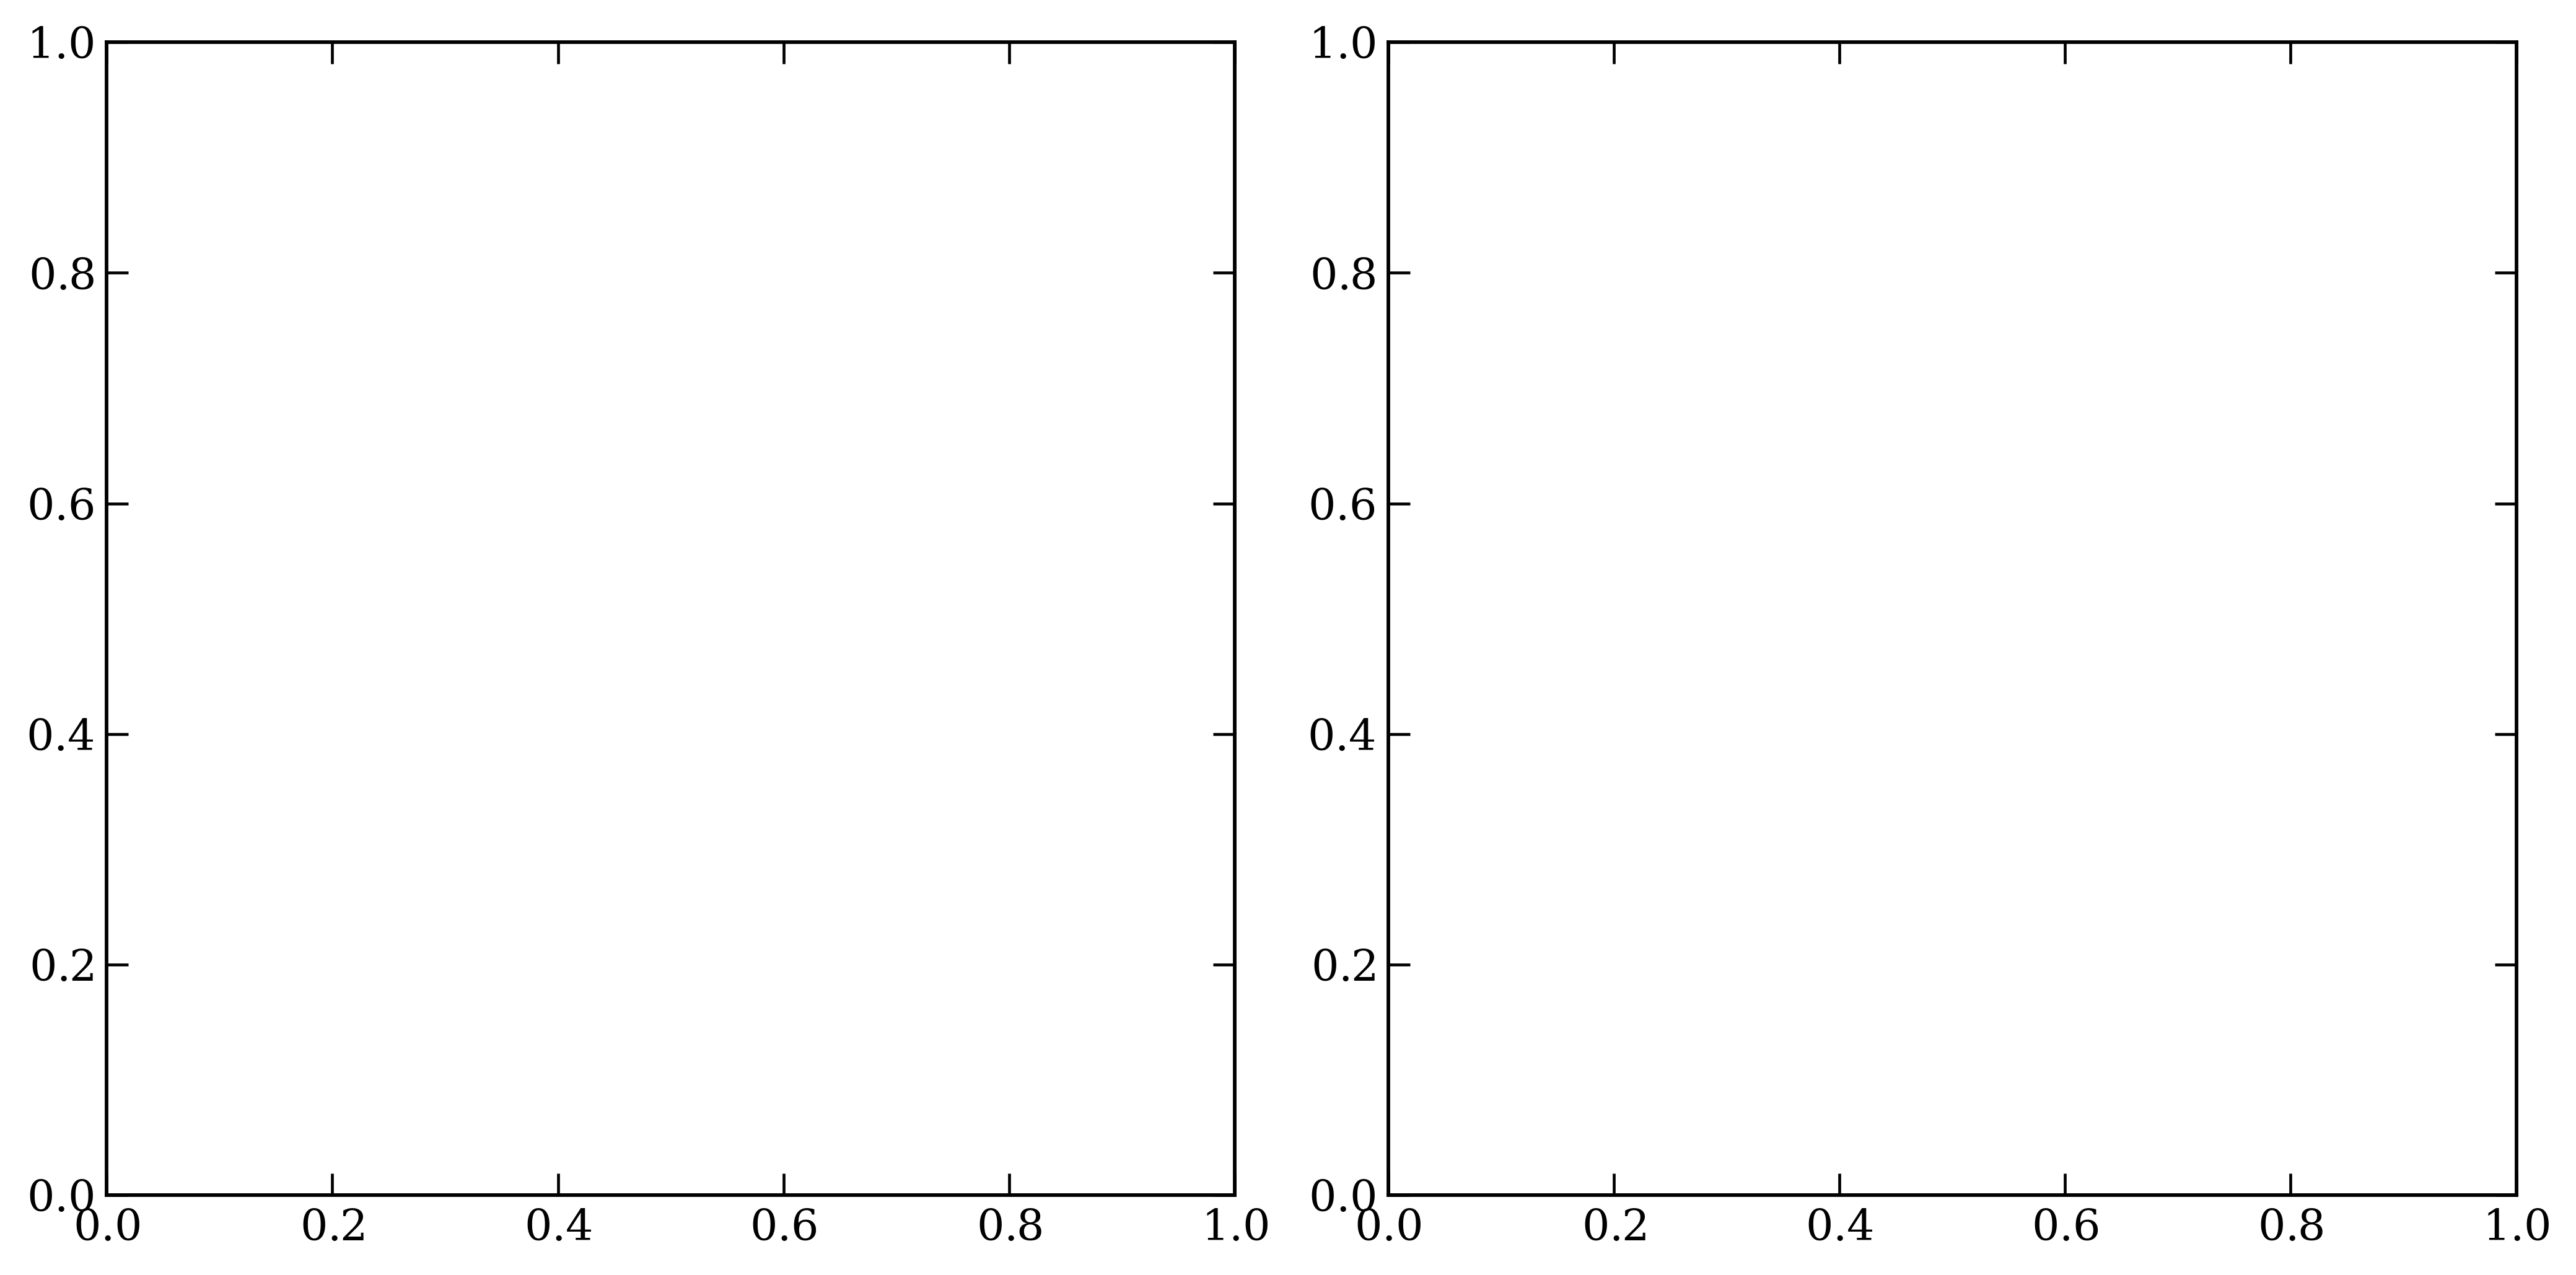

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))


ax[0].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.7,fmt='ro-', label=r'$\overline{l_{max}}$')
ax[0].errorbar(act_fwd[1:], lperc_av_fwd[1:,0], yerr=lperc_av_fwd[1:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')
ax[0].title.set_text('Forward')
ax[0].legend()  

ax[1].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.7, fmt='ro-', label=r'$\overline{l_{max}}$')
ax[1].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')
ax[1].title.set_text('Backward')
ax[1].legend()

if mode == 'dry':
   # ax[0].vlines(0.175, 0, 200, linestyle = '--', lw=1.5, color = 'k')
   # ax[0].fill_betweenx([0,200], 0.165, 0.185, color = 'green', alpha = 0.3)
   # ax[0].text(0.135, 200, r'$T_{\mathrm{KT}}(\overline{l_{max}})$', fontsize = 11)


    #ax[0].vlines(0.018, 0, 850, linestyle = '-.', lw=1.5, color = 'k')
    #ax.fill_betweenx([0,850], 0.0175, 0.0185, color = 'gray', alpha = 0.5)
    ax[0].set_ylim(ymax=220)
    ax[0].vlines(0.19, 0, 200, linestyle = '--', lw=1.5, color = 'k')
    ax[0].fill_betweenx([0,200], 0.18, 0.2, color = 'blue', alpha = 0.3)
    ax[0].text(0.205, 170, r'$T_{\mathrm{CV}} \approx 0.19$', fontsize = 11)
    #x.text(0.19,  100, r'$\zeta_{\mathrm{nucleation}}$', fontsize = 11)

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)

if save_figs:
    fig.savefig(os.path.join(fig_path, f'lmax_lperc_{mode}{LX}.png'), bbox_inches = 'tight', dpi = 420)